# VIXM Predictor using an adaBoost Model

This code is a marchine learning model to predict the sign of the return of the VIXM ETN for the next trading day.

A series of tickers are define in a list, and then used for the extraction (through Yahoo Finance) or calculation of the following features:

 * Close price
 * Returns
 * Volume
 * Garch Models
 * Return squared
 * SPY historical volatility
 * Day-of-the-week seasonality
 * Month-of-the-year seasonality
 * A custom number of principal components lagged on 1, 2, 3, 4 and 5 days representing historical movements
 
Several functions have been defined in two files:
 > `vixcoin_functions/feature_functions.py` and  
 > `vixcoin_functions/pca_and_training.py`
 
The model applied is the Adaboost Model.The investment strategy consist in an algorithmic trading that follows the signals from the model, which are  0 and 1 daily. The strategy buys VIXM when the signal is 1, and sell it when the signal comes back to 0.

The code includes analysis of profitability of the strategy, accuracy, as well as importance of features and tuning tools.




In [1]:
# Import appropriate modules

import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import yfinance as yf

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt


# Imports from internal packages
import sys

module_path1 = str(Path("vixcoin_functions/"))
if module_path1 not in sys.path:
    sys.path.append(module_path1)
from feature_functions import (garch_fit_and_predict, 
                               correlation_filter, 
                               retrieve_yahoo_close, 
                               retrieve_yahoo_volume,
                               retrieve_close_multiple_tickers
)


module_path2 = str(Path("vixcoin_functions/"))
if module_path2 not in sys.path:
    sys.path.append(module_path2)
from pca_and_training import (  split_training_test_data, 
                                scale, 
                                adaboost_pca, 
                                create_pca_lag, 
                                concatenate_lags, 
                                combine_train_test, 
                                concatenate_with_pca_lags, 
                                eliminate_nans_in_pca_data, 
                                random_over_sample

)

# CONTROL PANEL

In [2]:
# Key parameters of the model

# Min return to set up a positive signal
threshold= 0.00 

# Split of data
training_period_months = 120 

# Adaboost parameters
adaboost_estimators =6 #12 #14
max_depth = 2
learning_rate_adaboost = 1.7 #1.9 #1.8


# Inclusion of the first 4 components lag1
# n: number of components to include
number_of_pca_lag_component_to_include = 4
num_pca_components = 40


# Definition of demo mode or development mode
demo_mode = False
parameter_tuning_mode = False
run_multiple_tuning_iterations = False

#Dates
start_date = '2011-02-01'
end_date   = '2022-03-15'

start_date_volatilities=(pd.to_datetime(start_date)+DateOffset(days=-364)).date()


print(f"start date: {start_date}, end date: {end_date}, start date rolling volatilities: {start_date_volatilities}")


start date: 2011-02-01, end date: 2022-03-15, start date rolling volatilities: 2010-02-02


# Generation of the Features Matrix X

### X1: close prices
#### 40 units: 
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [3]:
# Ticker List: VIX must be in first position
ticker_list= ["VIXM","^VIX", "spy", 
              'GBPUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
              '^TNX', 'ZF=F', 'NQ=F','NKD=F',                                       
              'LQD',
              'AAPL', 'AMZN','MU','MSFT', 'BMY', 'PLD', 
              "FXI", 'FEZ', '^FTSE','^FCHI','^GSPC',
              "gld", "slv", 
              "ES=F","QM=F", "BIO=F", "AGG"
             ]
    
# Some of the less familiar tickers are listed below, together with others that can be good to try again in the future
# Bristol-Myers Squibb Company (BMY)
# E-Mini Nasdaq                (BIO=F)
# Euro spot                    (EURUSD)
# E-Mini S&P500                (ES=F)
# CAC 40                       (^FCHI)
# FTSE 100                     (^FTSE)
# SPDR EURO STOXX 50 ETF       (FEZ)
# FEDEX CORP                   (FDX)
# The Goldman Sachs Group, Inc.(GS)
# DAX PERFORMANCE-INDEX        (^GDAXI)
# S&P500 Index                 (^GSPC)
# HANG SENG INDEX              (^HSI)
# 13 Week Treasury Bill        (^IRX) 
# iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD)
# Micron Technology, Inc.      (MU)
# Microsoft Corporation        (MSFT)
# Nikkei/USD Futures,Dec-2021 (NKD=F)
# Nasdaq 100 Dec 21           (NQ=F)
# NVIDIA Corporation          (NVDA)
# E-Mini oil                  (QM=F)
# Prologis, Inc.              (PLD)
# Treasury Yield 10 Years     (^TNX) -- 1985
# Yen Denominated TOPIX Futures,D   (TPY=F)
# American Funds U.S. Government Securities Fund Class C (UGSCX) - 2001
# Energy Select Sector SPDR Fund    (XLE)
# Financial Select Sector SPDR Fund (XLF)
# U.S. Treasury Bond Futures,Dec-   (ZB=F) - 2000
# Five-Year US Treasury Note Futu   (ZF=F) - 2000

print(f"Current number of tickers: {len(ticker_list)}")


Current number of tickers: 29


In [4]:
# X1: Upload of close prices data using yahoo API

# Obs: raw means that the data can contain missing values
# In case of demo mode would use data stored in the csv file 
if demo_mode == True:
    close_prices_df_raw = pd.read_csv("demo_data/adaboost_close_prices.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
# In the general case retrieve from the API and save updated data to CVS file to use in future demo as needed
    close_prices_df_raw = retrieve_close_multiple_tickers(ticker_list,start_date = start_date, end_date = end_date)
                         
    close_prices_df_raw.to_csv("demo_data/adaboost_close_prices.csv", index=True)
print("Completed retrieve of close prices")

Processing Close VIXM
Processing Close ^VIX
Processing Close spy
Processing Close GBPUSD=X
Processing Close BRLUSD=X
Processing Close DX-Y.NYB
Processing Close USDJPY=X
Processing Close ^TNX
Processing Close ZF=F
Processing Close NQ=F
Processing Close NKD=F
Processing Close LQD
Processing Close AAPL
Processing Close AMZN
Processing Close MU
Processing Close MSFT
Processing Close BMY
Processing Close PLD
Processing Close FXI
Processing Close FEZ
Processing Close ^FTSE
Processing Close ^FCHI
Processing Close ^GSPC
Processing Close gld
Processing Close slv
Processing Close ES=F
Processing Close QM=F
Processing Close BIO=F
- BIO=F: No data found, symbol may be delisted
Sorry, Data not available for 'BIO=F': Exception is No Prices.
Processing Close AGG
Completed retrieve of close prices


In [5]:
close_prices_df_raw.head()


VIXM       ^VIX         spy  GBPUSD=X  BRLUSD=X   DX-Y.NYB  \
Date                                                                           
2011-02-01  274.839996  17.629999  105.406410  1.603001  0.599880  77.070000   
2011-02-02  274.239990  17.299999  105.204865  1.613606  0.600528  77.160004   
2011-02-03  272.600006  16.690001  105.438683  1.620483  0.601431  77.750000   
2011-02-04  269.239990  15.930000  105.736961  1.613450  0.599377  78.040001   
2011-02-07  265.839996  16.280001  106.398087  1.609969  0.615688  78.029999   

             USDJPY=X   ^TNX        ZF=F     NQ=F  ...        FEZ  \
Date                                               ...              
2011-02-01  82.070000  3.443  118.070312  2322.50  ...  28.844316   
2011-02-02  81.390999  3.489  117.687500  2319.75  ...  28.689478   
2011-02-03  81.492996  3.541  117.398438  2321.75  ...  28.393854   
2011-02-04  81.650002  3.652  116.851562  2337.50  ...  28.358662   
2011-02-07  82.220001  3.644  116.882812  2345.00  ...  28.499428   

                  ^FTSE        ^FCHI        ^GSPC         gld        slv  \
Date                                                                       
2011-02-01  5957.799805  4072.620117  1307.589966  130.800003  27.870001   
2011-02-02  6000.100098  4066.530029  1304.030029  130.449997  27.690001   
2011-02-03  5983.299805  4036.590088  1307.099976  132.199997  28.290001   
2011-02-04  5997.399902  4047.209961  1310.869995  131.660004  28.400000   
2011-02-07  6051.000000  4090.800049  1319.050049  131.679993  28.660000   

               ES=F       QM=F  BIO=F        AGG  
Date                                              
2011-02-01  1302.75  90.775002   None  79.783615  
2011-02-02  1300.00  90.849998   None  79.692505  
2011-02-03  1303.25  90.550003   None  79.396492  
2011-02-04  1307.25  89.025002   None  79.130852  
2011-02-07  1315.75  87.474998   None  79.161224  

[5 rows x 29 columns]

In [6]:
# X1 (close prices) - Fill of missing values
close_prices_df = close_prices_df_raw.ffill(axis='rows')
#close_prices_df = close_prices_df_raw.bfill(axis='rows')

# Apply correlation filter to keep just series with some minimum level of correlation of 0.05
close_prices_component_df  =  correlation_filter(close_prices_df, min_corr=0.05, key_column='VIXM', eliminate_first_column=False)
#close_prices_df

In [7]:
# Filling price_t with price_t-1 if price_t not available
close_prices_component_df  = close_prices_component_df.ffill(axis='rows')

# In the case the first missing value was at the first position, we fill with the first price available - this may be an issue. We are filling with future data. Will disable.
# close_prices_componennt_df = close_prices_component_df.bfill(axis='rows')

# First columns is not given back, so we take opportunity to rename them
X1_no_suffix = close_prices_component_df
X1           = X1_no_suffix.add_suffix("_close")

# Additional time series for easy manipulation of VIXM close and returns
vixm     = X1['VIXM_close']
vixm_ret = X1['VIXM_close'].pct_change()

vixm     = pd.DataFrame([vixm]).T
vixm.columns = ['VIXM']  # 'vixm' will represent the close and 'vixm_ret' the return

vixm_ret = pd.DataFrame([vixm_ret]).T
vixm_ret.columns = ['VIXM_ret']

if demo_mode==False:
        print(X1.tail())

print("Completed inclusion of close prices")

            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2022-03-09   34.310001   32.450001  426.086304        1.309929   
2022-03-10   34.470001   30.230000  424.162292        1.318565   
2022-03-11   34.720001   30.750000  418.769043        1.310324   
2022-03-14   35.459999   31.770000  415.708557        1.305030   
2022-03-15   35.459999   31.770000  415.708557        1.301185   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2022-03-09        0.197675       97.970001      115.722000       1.948   
2022-03-10        0.199541       98.510002      115.908997       2.011   
2022-03-11        0.199613       99.120003      116.179001       2.004   
2022-03-14        0.197103       99.059998      117.528999       2.140   
2022-03-15        0.195259       99.059998      118.218002       2.140   

            ZF=F_c

In [8]:
# close_prices_df
# X1

In [9]:
# Presentation graphs of the SPY and the VIX

presentation_graph=pd.concat([X1['spy_close'], 2.5*X1['VIXM_close']],axis=1).hvplot(
        title='VIXM and S&P (Scale adjusted)',
        width=650
)
presentation_graph


graph1=X1['spy_close'].hvplot(
                title= "SPY: iShares S&P 500 ETF Close Price",
                ylabel= 'Close Price [$]',
                width=650
) 
presentation_graph + graph1

:Layout
   .NdOverlay.I     :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.Spy_close :Curve   [Date]   (spy_close)

### X2: security returns

In [10]:
# Inclusion of security returns X2
# Include returns that are (minimal) correlated with the VIXM return

security_returns_df = close_prices_df.pct_change()
security_returns_component_df = correlation_filter(
                                        security_returns_df, 
                                        min_corr = 0.05, 
                                        key_column ='VIXM', 
                                        eliminate_first_column = False
)

# The generation of a suffix is necesary when evaluating feature importance for time series identification
X2_no_suffix = security_returns_component_df
X2           = X2_no_suffix.add_suffix("_returns")

if demo_mode==False:
        display(X2)
        
print("Completed inclusion of returns")


VIXM_returns  ^VIX_returns  spy_returns  DX-Y.NYB_returns  \
Date                                                                    
2011-02-01           NaN           NaN          NaN               NaN   
2011-02-02     -0.002183     -0.018718    -0.001912          0.001168   
2011-02-03     -0.005980     -0.035260     0.002223          0.007646   
2011-02-04     -0.012326     -0.045536     0.002829          0.003730   
2011-02-07     -0.012628      0.021971     0.006253         -0.000128   
...                  ...           ...          ...               ...   
2022-03-09     -0.022229     -0.076288     0.026811         -0.011003   
2022-03-10      0.004663     -0.068413    -0.004516          0.005512   
2022-03-11      0.007253      0.017201    -0.012715          0.006192   
2022-03-14      0.021313      0.033171    -0.007308         -0.000605   
2022-03-15      0.000000      0.000000     0.000000          0.000000   

            ^TNX_returns  ZF=F_returns  NQ=F_returns  NKD=F_returns  \
Date                                                                  
2011-02-01           NaN           NaN           NaN            NaN   
2011-02-02      0.013360     -0.003242     -0.001184       0.012095   
2011-02-03      0.014904     -0.002456      0.000862       0.004780   
2011-02-04      0.031347     -0.004658      0.006784       0.012369   
2011-02-07     -0.002191      0.000267      0.003209       0.002350   
...                  ...           ...           ...            ...   
2022-03-09      0.040598     -0.002975      0.035257       0.024194   
2022-03-10      0.032341     -0.002454     -0.010830      -0.003937   
2022-03-11     -0.003481     -0.001064     -0.021640       0.000000   
2022-03-14      0.067864     -0.004991     -0.018545      -0.008103   
2022-03-15      0.000000      0.000000      0.000000       0.000000   

            LQD_returns  AAPL_returns  ...  PLD_returns  FXI_returns  \
Date                                   ...                             
2011-02-01          NaN           NaN  ...          NaN          NaN   
2011-02-02    -0.001945     -0.002058  ...    -0.008128    -0.001167   
2011-02-03    -0.002415     -0.002556  ...     0.004249    -0.002570   
2011-02-04    -0.003072      0.008910  ...     0.000302     0.004452   
2011-02-07     0.001121      0.015527  ...     0.012085    -0.009330   
...                 ...           ...  ...          ...          ...   
2022-03-09     0.001730      0.034997  ...     0.023743     0.016629   
2022-03-10    -0.011429     -0.027186  ...     0.003987    -0.045297   
2022-03-11    -0.000416     -0.023909  ...    -0.021512    -0.042175   
2022-03-14    -0.014478     -0.026562  ...     0.009064    -0.067079   
2022-03-15     0.000000      0.000000  ...     0.000000     0.000000   

            FEZ_returns  ^FTSE_returns  ^FCHI_returns  ^GSPC_returns  \
Date                                                                   
2011-02-01          NaN            NaN            NaN            NaN   
2011-02-02    -0.005368       0.007100      -0.001495      -0.002723   
2011-02-03    -0.010304      -0.002800      -0.007363       0.002354   
2011-02-04    -0.001239       0.002357       0.002631       0.002884   
2011-02-07     0.004964       0.008937       0.010770       0.006240   
...                 ...            ...            ...            ...   
2022-03-09     0.070048       0.032538       0.071252       0.025698   
2022-03-10    -0.029847      -0.012739      -0.028277      -0.004292   
2022-03-11    -0.008532       0.007959       0.008546      -0.012962   
2022-03-14     0.021382       0.005297       0.017522      -0.007421   
2022-03-15     0.000000       0.000000       0.000000       0.000000   

            slv_returns  ES=F_returns  QM=F_returns  AGG_returns  
Date                                                              
2011-02-01          NaN           NaN           NaN          NaN  
2011-02-02    -0.006459     -0.002111      0.000826    -0.00114

Completed inclusion of returns


In [11]:
#security_returns_component_df.head()
#X2

### X3: security volume

In [12]:
# inclusion of security volume X3
volume_list = ticker_list[0:len(ticker_list)]

# Replace the ^VIX volume by VXX volume, since ^VIX is an index and will not present volume.
# volume_list[1]='VXX' -- this only can be deon for short historical history

def retrieve_volume(volume_dict, volume_list):
    """
    This function retrieve volume trades from a list of tickers
    
    Args:
    volume_dict : an initial dictionary to populate
    volume_list : the list of tickers for which to retrieve the volume
    
    
    Return:
    The original dictionary filled with the volume of the list of tickers
    """
    for ticker in volume_list:        
        volume              = retrieve_yahoo_volume(ticker, start_date=start_date, end_date=end_date)
        volume_dict[ticker] = volume
    return volume_dict

if demo_mode == True:
    volume_df = pd.read_csv("demo_data/adaboost_volume.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    volume_dict   = {}
    volume_dict   = retrieve_volume(volume_dict, volume_list)
    volume_df_raw = pd.DataFrame(volume_dict)
    volume_df     = volume_df_raw.ffill(axis='rows')
    volume_df.to_csv("demo_data/adaboost_volume.csv", index=True)
    
print("Completed retrieve of volume")

volume_df_with_vixm = pd.concat([vixm_ret, volume_df], axis=1)
print(volume_df_with_vixm.corr())

volume_component_df = correlation_filter(volume_df_with_vixm, min_corr=0.10, key_column='VIXM_ret', eliminate_first_column=True )

X3_no_suffix = volume_component_df
X3 = X3_no_suffix.add_suffix("_volume")

if demo_mode==False:
        display(X3)

Processing Volume VIXM
Processing Volume ^VIX
Processing Volume spy
Processing Volume GBPUSD=X
Processing Volume BRLUSD=X
Processing Volume DX-Y.NYB
Processing Volume USDJPY=X
Processing Volume ^TNX
Processing Volume ZF=F
Processing Volume NQ=F
Processing Volume NKD=F
Processing Volume LQD
Processing Volume AAPL
Processing Volume AMZN
Processing Volume MU
Processing Volume MSFT
Processing Volume BMY
Processing Volume PLD
Processing Volume FXI
Processing Volume FEZ
Processing Volume ^FTSE
Processing Volume ^FCHI
Processing Volume ^GSPC
Processing Volume gld
Processing Volume slv
Processing Volume ES=F
Processing Volume QM=F
Processing Volume BIO=F
- BIO=F: No data found, symbol may be delisted
Sorry, Data not available for 'BIO=F': Exception is No Prices.
Processing Volume AGG
Completed retrieve of volume
          VIXM_ret      VIXM  ^VIX       spy  GBPUSD=X  BRLUSD=X  DX-Y.NYB  \
VIXM_ret  1.000000  0.126500   NaN  0.212662       NaN       NaN -0.019293   
VIXM      0.126500  1.000000

VIXM_volume   spy_volume  NQ=F_volume  AMZN_volume  MSFT_volume  \
Date                                                                          
2011-02-01       1825.0  167194300.0     300511.0    5085900.0   62810700.0   
2011-02-02       1575.0  118323600.0     193313.0    4547500.0   45824000.0   
2011-02-03        800.0  145886700.0     258037.0    3678900.0   60340100.0   
2011-02-04       3725.0  134634800.0     224139.0    4347800.0   40412200.0   
2011-02-07       2375.0  112439100.0     240695.0    5254700.0   68980900.0   
...                 ...          ...          ...          ...          ...   
2022-03-09     294400.0  116990800.0     650826.0    4132800.0   35204500.0   
2022-03-10     121600.0   93972700.0     611077.0    6753100.0   30628000.0   
2022-03-11      65600.0   95529600.0     439890.0    3440500.0   27192600.0   
2022-03-14     234100.0   95729200.0     402608.0    3704300.0   30660700.0   
2022-03-15     234100.0   95729200.0     402608.0    3704300.0   30660700.0   

            FXI_volume  FEZ_volume  ^FTSE_volume  ^FCHI_volume  ^GSPC_volume  \
Date                                                                           
2011-02-01  18007400.0     74800.0  9.633495e+08   145716600.0  5.164500e+09   
2011-02-02   8566900.0    149000.0  8.783184e+08   135369200.0  4.098260e+09   
2011-02-03  10378200.0     62800.0  1.033275e+09   132587800.0  4.370990e+09   
2011-02-04  10429400.0     44300.0  7.638633e+08   125922000.0  3.925950e+09   
2011-02-07  11147600.0     20700.0  6.948750e+08   135168800.0  3.902270e+09   
...                ...         ...           ...           ...           ...   
2022-03-09  40442000.0  10214700.0  1.239464e+09   189777300.0  4.220180e+09   
2022-03-10  59032900.0   6629600.0  1.139094e+09   148747200.0  4.008690e+09   
2022-03-11  54446700.0   4602200.0  9.732072e+08   136389500.0  3.877430e+09   
2022-03-14  88118800.0   5443900.0  9.160486e+08   113227400.0  4.757600e+09   
2022-03-15  88118800.0   5443900.0  9.160486e+08   113227400.0  4.757600e+09   

            gld_volume  ES=F_volume  QM=F_volume  
Date                                              
2011-02-01  15363700.0    2089240.0      11969.0  
2011-02-02  10082000.0    1396167.0       7884.0  
2011-02-03  17374700.0    1828391.0       9442.0  
2011-02-04  15214300.0    1585618.0      11420.0  
2011-02-07   7176300.0    1501112.0       7007.0  
...                ...          ...          ...  
2022-03-09  26839700.0    1659520.0      58064.0  
2022-03-10  18455200.0    1745090.0      54024.0  
2022-03-11  14818900.0    1645055.0      42244.0  
2022-03-14  13186400.0    1438651.0      35434.0  
2022-03-15  13186400.0    1438651.0      35434.0  

[2901 rows x 13 columns]

In [13]:
#volume_component_df
#X3
X3.info()
#volume_df_with_vixm

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2901 entries, 2011-02-01 to 2022-03-15
Freq: B
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VIXM_volume   2901 non-null   float64
 1   spy_volume    2901 non-null   float64
 2   NQ=F_volume   2901 non-null   float64
 3   AMZN_volume   2901 non-null   float64
 4   MSFT_volume   2901 non-null   float64
 5   FXI_volume    2901 non-null   float64
 6   FEZ_volume    2901 non-null   float64
 7   ^FTSE_volume  2901 non-null   float64
 8   ^FCHI_volume  2901 non-null   float64
 9   ^GSPC_volume  2901 non-null   float64
 10  gld_volume    2901 non-null   float64
 11  ES=F_volume   2901 non-null   float64
 12  QM=F_volume   2901 non-null   float64
dtypes: float64(13)
memory usage: 381.8 KB


### X4: GARCH Models1
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution of errors

In [14]:
# Inclusion of GARCH series X4
garch_series_df=pd.DataFrame()

not_to_include=['BIO=F']


for ticker in ticker_list:
    
        if ticker in not_to_include:
            continue
    
        if demo_mode == True:
            print_series = False
        else:
            print_series = True
        garch_series_df[ticker]=garch_fit_and_predict(security_returns_df[ticker], ticker, horizon=1, p=1, q=1, o=1, print_series_name=print_series)
            
        
X4_no_suffix = garch_series_df
X4           = X4_no_suffix.add_suffix("_garch")


if demo_mode == False:
    display(X4)

print('GARCH Process fit and predictions completed')


Processing series: VIXM.....
Processing series: ^VIX.....
Processing series: spy.....
Processing series: GBPUSD=X.....
Processing series: BRLUSD=X.....
Processing series: DX-Y.NYB.....
Processing series: USDJPY=X.....
Processing series: ^TNX.....
Processing series: ZF=F.....
Processing series: NQ=F.....
Processing series: NKD=F.....
Processing series: LQD.....
Processing series: AAPL.....
Processing series: AMZN.....
Processing series: MU.....
Processing series: MSFT.....
Processing series: BMY.....
Processing series: PLD.....
Processing series: FXI.....
Processing series: FEZ.....
Processing series: ^FTSE.....
Processing series: ^FCHI.....
Processing series: ^GSPC.....
Processing series: gld.....
Processing series: slv.....
Processing series: ES=F.....
Processing series: QM=F.....
Processing series: AGG.....


VIXM_garch  ^VIX_garch  spy_garch  GBPUSD=X_garch  BRLUSD=X_garch  \
Date                                                                            
2011-02-02    1.660322    0.665683   0.693849        0.456969        1.330934   
2011-02-03    1.559618    0.637380   0.649128        0.454314        1.298079   
2011-02-04    1.498432    0.615755   0.610244        0.457003        1.268840   
2011-02-07    1.449762    0.606542   0.576604        0.452103        1.288358   
2011-02-08    1.415238    0.592426   0.547648        0.445860        1.257660   
...                ...         ...        ...             ...             ...   
2022-03-09    2.645840    0.853464   1.778195        0.513466        0.892519   
2022-03-10    2.416632    0.784765   1.640031        0.514222        0.882348   
2022-03-11    2.236528    0.733204   1.675996        0.523392        0.863301   
2022-03-14    2.307140    0.706916   1.588153        0.521586        0.912173   
2022-03-15    4.446562    0.447838   2.085886        0.266587        0.859800   

            DX-Y.NYB_garch  USDJPY=X_garch  ^TNX_garch  ZF=F_garch  \
Date                                                                 
2011-02-02        0.401568        0.603646    1.607375    2.832613   
2011-02-03        0.423165        0.580917    1.588140    2.806504   
2011-02-04        0.422112        0.560653    1.605471    2.920372   
2011-02-07        0.414671        0.568936    1.576512    2.838179   
2011-02-08        0.407470        0.547587    1.571350    2.945364   
...                    ...             ...         ...         ...   
2022-03-09        0.475434        0.393613    3.858053    3.580263   
2022-03-10        0.479467        0.383871    3.795286    3.519736   
2022-03-11        0.486623        0.377236    3.714227    3.426172   
2022-03-14        0.477881        0.475387    3.727587    3.510835   
2022-03-15        0.220123        0.233451   13.300700   11.624376   

            NQ=F_garch  ...  FXI_garch  FEZ_garch  ^FTSE_garch  ^FCHI_garch  \
Date                    ...                                                   
2011-02-02    0.836259  ...   1.149461   1.236117     0.724055     0.835336   
2011-02-03    0.793470  ...   1.127006   1.261610     0.707039     0.877710   
2011-02-04    0.755630  ...   1.104292   1.193534     0.680748     0.837571   
2011-02-07    0.722289  ...   1.125473   1.132826     0.656820     0.800625   
2011-02-08    0.693023  ...   1.101714   1.087629     0.635090     0.766678   
...                ...  ...        ...        ...          ...          ...   
2022-03-09    2.245890  ...   2.055423   3.540338     2.000588     2.897257   
2022-03-10    2.155633  ...   2.483254   3.582433     1.964694     3.047062   
2022-03-11    2.308802  ...   2.763949   3.370310     1.846848     2.861147   
2022-03-14    2.355247  ...   3.459087   3.172061     1.736906     2.687111   
2022-03-15    4.705734  ...  10.977328   8.791961     2.671226     6.371823   

            ^GSPC_garch  gld_garch  slv_garch  ES=F_garch  QM=F_garch  \
Date                                                                    
2011-02-02     0.707109   0.708788   2.048384    0.713499    0.205258   
2011-02-03     0.660858   0.767004   2.065468    0.665188    0.191883   
2011-02-04     0.620622   0.757426   2.031265    0.623396    0.195355   
2011-02-07     0.585794   0.744372   2.005721    0.588878    0.199136   
2011-02-08     0.555799   0.777595   2.102090    0.558240    0.187995   
...                 ...        ...        ...         ...         ...   
2022-03-09     1.779911   1.291621   1.746720    1.788146    0.641886   
2022-03-10     1.638528   1.263770   1.728277    1.641842    0.590899   
2022-03-11     1.681002   1.241390   1.702546    1.687747    0.543683   
2022-03-14     1.593488   1.242996   1.746420    1.590630    0.557477   
2022-03-15     2.098921   1.475234   2.950001    2.081710    0.254519   

            AGG_garch  
Date                   
2011-02-02   2.121035

GARCH Process fit and predictions completed


In [15]:
garch_series_df

VIXM      ^VIX       spy  GBPUSD=X  BRLUSD=X  DX-Y.NYB  \
Date                                                                     
2011-02-02  1.660322  0.665683  0.693849  0.456969  1.330934  0.401568   
2011-02-03  1.559618  0.637380  0.649128  0.454314  1.298079  0.423165   
2011-02-04  1.498432  0.615755  0.610244  0.457003  1.268840  0.422112   
2011-02-07  1.449762  0.606542  0.576604  0.452103  1.288358  0.414671   
2011-02-08  1.415238  0.592426  0.547648  0.445860  1.257660  0.407470   
...              ...       ...       ...       ...       ...       ...   
2022-03-09  2.645840  0.853464  1.778195  0.513466  0.892519  0.475434   
2022-03-10  2.416632  0.784765  1.640031  0.514222  0.882348  0.479467   
2022-03-11  2.236528  0.733204  1.675996  0.523392  0.863301  0.486623   
2022-03-14  2.307140  0.706916  1.588153  0.521586  0.912173  0.477881   
2022-03-15  4.446562  0.447838  2.085886  0.266587  0.859800  0.220123   

            USDJPY=X       ^TNX       ZF=F      NQ=F  ...        FXI  \
Date                                                  ...              
2011-02-02  0.603646   1.607375   2.832613  0.836259  ...   1.149461   
2011-02-03  0.580917   1.588140   2.806504  0.793470  ...   1.127006   
2011-02-04  0.560653   1.605471   2.920372  0.755630  ...   1.104292   
2011-02-07  0.568936   1.576512   2.838179  0.722289  ...   1.125473   
2011-02-08  0.547587   1.571350   2.945364  0.693023  ...   1.101714   
...              ...        ...        ...       ...  ...        ...   
2022-03-09  0.393613   3.858053   3.580263  2.245890  ...   2.055423   
2022-03-10  0.383871   3.795286   3.519736  2.155633  ...   2.483254   
2022-03-11  0.377236   3.714227   3.426172  2.308802  ...   2.763949   
2022-03-14  0.475387   3.727587   3.510835  2.355247  ...   3.459087   
2022-03-15  0.233451  13.300700  11.624376  4.705734  ...  10.977328   

                 FEZ     ^FTSE     ^FCHI     ^GSPC       gld       slv  \
Date                                                                     
2011-02-02  1.236117  0.724055  0.835336  0.707109  0.708788  2.048384   
2011-02-03  1.261610  0.707039  0.877710  0.660858  0.767004  2.065468   
2011-02-04  1.193534  0.680748  0.837571  0.620622  0.757426  2.031265   
2011-02-07  1.132826  0.656820  0.800625  0.585794  0.744372  2.005721   
2011-02-08  1.087629  0.635090  0.766678  0.555799  0.777595  2.102090   
...              ...       ...       ...       ...       ...       ...   
2022-03-09  3.540338  2.000588  2.897257  1.779911  1.291621  1.746720   
2022-03-10  3.582433  1.964694  3.047062  1.638528  1.263770  1.728277   
2022-03-11  3.370310  1.846848  2.861147  1.681002  1.241390  1.702546   
2022-03-14  3.172061  1.736906  2.687111  1.593488  1.242996  1.746420   
2022-03-15  8.791961  2.671226  6.371823  2.098921  1.475234  2.950001   

                ES=F      QM=F        AGG  
Date                                       
2011-02-02  0.713499  0.205258   2.121035  
2011-02-03  0.665188  0.191883   2.394995  
2011-02-04  0.623396  0.195355   2.538236  
2011-02-07  0.588878  0.199136   2.374344  
2011-02-08  0.558240  0.187995   2.451475  
...              ...       ...        ...  
2022-03-09  1.788146  0.641886   4.137977  
2022-03-10  1.641842  0.590899   4.268071  
2022-03-11  1.687747  0.543683   3.916514  
2022-03-14  1.590630  0.557477   4.910911  
2022-03-15  2.081710  0.254519  20.189842  

[2900 rows x 28 columns]

### X5: Return squared


In [16]:
# Inclusion of return squares in X5

returns_squared_df              = security_returns_df**2
returns_squared_and_vixm_ret_df = pd.concat([vixm_ret,returns_squared_df], axis=1)

returns_squared_component_df    = correlation_filter(returns_squared_and_vixm_ret_df, min_corr=0.05, key_column='VIXM', eliminate_first_column=True)

X5_no_suffix_df = returns_squared_component_df
X5              = X5_no_suffix_df.add_suffix("_return_squared")

if demo_mode == False:
    display(X5)
print("Completed inclusion of return squared")

VIXM_return_squared  ^VIX_return_squared  spy_return_squared  \
Date                                                                       
2011-02-01                  NaN                  NaN                 NaN   
2011-02-02             0.000005             0.000350            0.000004   
2011-02-03             0.000036             0.001243            0.000005   
2011-02-04             0.000152             0.002074            0.000008   
2011-02-07             0.000159             0.000483            0.000039   
...                         ...                  ...                 ...   
2022-03-09             0.000494             0.005820            0.000719   
2022-03-10             0.000022             0.004680            0.000020   
2022-03-11             0.000053             0.000296            0.000162   
2022-03-14             0.000454             0.001100            0.000053   
2022-03-15             0.000000             0.000000            0.000000   

            GBPUSD=X_return_squared  DX-Y.NYB_return_squared  \
Date                                                           
2011-02-01                      NaN                      NaN   
2011-02-02             4.376950e-05             1.363806e-06   
2011-02-03             1.816336e-05             5.846745e-05   
2011-02-04             1.883738e-05             1.391227e-05   
2011-02-07             4.654203e-06             1.642673e-08   
...                             ...                      ...   
2022-03-09             9.834516e-07             1.210747e-04   
2022-03-10             4.346517e-05             3.038105e-05   
2022-03-11             3.906499e-05             3.834422e-05   
2022-03-14             1.632465e-05             3.664840e-07   
2022-03-15             8.678381e-06             0.000000e+00   

            USDJPY=X_return_squared  ^TNX_return_squared  ZF=F_return_squared  \
Date                                                                            
2011-02-01                      NaN                  NaN                  NaN   
2011-02-02                 0.000068             0.000179         1.051213e-05   
2011-02-03                 0.000002             0.000222         6.032854e-06   
2011-02-04                 0.000004             0.000983         2.169959e-05   
2011-02-07                 0.000049             0.000005         7.152057e-08   
...                             ...                  ...                  ...   
2022-03-09                 0.000009             0.001648         8.851854e-06   
2022-03-10                 0.000003             0.001046         6.020059e-06   
2022-03-11                 0.000005             0.000012         1.131282e-06   
2022-03-14                 0.000135             0.004606         2.491024e-05   
2022-03-15                 0.000034             0.000000         0.000000e+00   

            NQ=F_return_squared  NKD=F_return_squared  ...  \
Date                                                   ...   
2011-02-01                  NaN                   NaN  ...   
2011-02-02         1.402019e-06              0.000146  ...   
2011-02-03         7.433231e-07              0.000023  ...   
2011-02-04         4.601826e-05              0.000153  ...   
2011-02-07         1.029483e-05              0.000006  ...   
...                         ...                   ...  ...   
2022-03-09         1.243031e-03              0.000585  ...   
2022-03-10         1.172931e-04              0.000016  ...   
2022-03-11         4.682863e-04              0.000000  ...   
2022-03-14         3.439166e-04              0.000066  ...   
2022-03-15         0.000000e+00              0.000000  ...   

            PLD_return_squared  FXI_return_squared  FEZ_return_squared  \
Date                                                                     
2011-02-01                 NaN                 NaN                 NaN   
2011-02-02        6.606675e-05            0.000001            0.000029   
2011-02-03        1.805576e-05   

Completed inclusion of return squared


In [17]:
#returns_squared_df
#X5

### X8: volatility of the SPY in several rolling windows

In [18]:
# SPY volatility on varios tracks X8

#if demo_mode == True:
#    close_price_spy_df = pd.read_csv("demo_data/adaboost_spy_data.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
    
# Retrieve yahoo close prices for spy, so to be able to calculate rolling volatilities
#else:
close_price_spy_df = retrieve_yahoo_close('spy', start_date= start_date_volatilities, end_date=end_date)  #MATCH DATE ABOVE
close_price_spy_df.to_csv("demo_data/adaboost_spy_data.csv", index=True)
    
# Calculate returns
spy_returns_df = close_price_spy_df.pct_change()

#Initialize dataframe for volatility
spy_volatility = pd.DataFrame()

# Define rolling windows to create
windows_for_lag = [10, 20, 30, 60, 90, 120, 180, 200, 260]

# Loop to create the volatilities
for window_size in windows_for_lag:
    column_name=f"{window_size}_spy_rolling_volatility"
    spy_volatility[column_name] = spy_returns_df.rolling(window = window_size).std()

# Concatenate to vix to uniform index
X8 = pd.concat([vixm, spy_volatility], axis=1)

# Define min and max values for the window
X8 = X8.loc[start_date:end_date,:]        
    
# Fill missing data, and delete vixm, that was already used to uniform the index
X8 = X8.ffill()
X8 = X8.iloc[:,1:]

# Setting for demo
if demo_mode == False:
    X8.shape
print("Inclusion of rolling volatilities completed")

Processing Close spy
Inclusion of rolling volatilities completed


In [19]:
#spy_volatility
#X8

### X10: Day of the Week effect

In [20]:
# Construct dataframe with the days of the week  
# 0: Monday, 6: Sunday

# Calculate list of day of week
day_of_week = close_prices_df['VIXM'].index.dayofweek

# Contruct dataframe
day_of_week_df = pd.DataFrame(day_of_week, index = close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the day of the week as boolean
day_of_week_df = pd.concat([day_of_week_df, pd.get_dummies(day_of_week_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
day_of_week_df.drop(columns=["Date"], inplace=True)
day_of_week_df.columns=["Mon", "Tue", "Wed","Thu","Fri"]
day_of_week_df

X10 = day_of_week_df
#X10.drop(columns=["Mon", "Wed", "Thu","Fri"], inplace=True)
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of day of the week effect")
X10

(2901, 5)

Mon  Tue  Wed  Thu  Fri
0    1    0    0    0      581
     0    0    0    1      580
               1    0      580
          1    0    0      580
1    0    0    0    0      580
dtype: int64

Completed inclusion of day of the week effect


Mon  Tue  Wed  Thu  Fri
Date                               
2011-02-01    0    1    0    0    0
2011-02-02    0    0    1    0    0
2011-02-03    0    0    0    1    0
2011-02-04    0    0    0    0    1
2011-02-07    1    0    0    0    0
...         ...  ...  ...  ...  ...
2022-03-09    0    0    1    0    0
2022-03-10    0    0    0    1    0
2022-03-11    0    0    0    0    1
2022-03-14    1    0    0    0    0
2022-03-15    0    1    0    0    0

[2901 rows x 5 columns]

### X11: Month effect

In [21]:
# Construct dataframe with the month of the observation

# Calculate list of month
month = close_prices_df['VIXM'].index.month

# Contruct dataframe
month_df = pd.DataFrame(month, index = close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the month as boolean
month_df = pd.concat([month_df,pd.get_dummies(month_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
month_df.drop(columns=["Date"], inplace=True)
month_df.columns=["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_df

X11=month_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of month effect")
X11

(2901, 5)

Mon  Tue  Wed  Thu  Fri
0    1    0    0    0      581
     0    0    0    1      580
               1    0      580
          1    0    0      580
1    0    0    0    0      580
dtype: int64

Completed inclusion of month effect


Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
Date                                                                  
2011-02-01    0    1    0    0    0    0    0    0    0    0    0    0
2011-02-02    0    1    0    0    0    0    0    0    0    0    0    0
2011-02-03    0    1    0    0    0    0    0    0    0    0    0    0
2011-02-04    0    1    0    0    0    0    0    0    0    0    0    0
2011-02-07    0    1    0    0    0    0    0    0    0    0    0    0
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2022-03-09    0    0    1    0    0    0    0    0    0    0    0    0
2022-03-10    0    0    1    0    0    0    0    0    0    0    0    0
2022-03-11    0    0    1    0    0    0    0    0    0    0    0    0
2022-03-14    0    0    1    0    0    0    0    0    0    0    0    0
2022-03-15    0    0    1    0    0    0    0    0    0    0    0    0

[2901 rows x 12 columns]

# GENERATION OF THE FEATURE MATRIX **X**

In [22]:
# Concatenation of all sources of data
XY=pd.concat([X1, X2, X3, X4, X5,   X8,   X10, X11], axis=1) # X6,X7,X9 X11  These are features used for prediction of VIX that do not add value here

# We re-define the start_date to the effective start_date
start_date = XY.index.min() + DateOffset(days=1)
XY = XY.loc[start_date:end_date]

if parameter_tuning_mode == True:
    print(XY.shape)
    print(XY.head())
    print(XY)

if parameter_tuning_mode == True:
    print(XY.shape)

# Interpolation is not applied to numerical variables. We are just going to drop those.
print(f"XY.shape:  {XY.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X1.shape:  {X1.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X2.shape:  {X2.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X3.shape:  {X3.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X4.shape:  {X4.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X5.shape:  {X5.shape}, {XY.index.min()}, {XY.index.max()} ")

print(f"X8.shape:  {X8.shape}, {XY.index.min()}, {XY.index.max()} ")

print(f"X10.shape: {X10.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X11.shape: {X11.shape}, {XY.index.min()}, {XY.index.max()} ")

#display(XY.isna().head(40))
#display(XY.isna().sum().tail(40))
#XY=XY.dropna()
if parameter_tuning_mode == True:
    XY.shape
    XY.head()
    

(2900, 145)
            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-02  274.239990   17.299999  105.204865        1.613606   
2011-02-03  272.600006   16.690001  105.438683        1.620483   
2011-02-04  269.239990   15.930000  105.736961        1.613450   
2011-02-07  265.839996   16.280001  106.398087        1.609969   
2011-02-08  262.239990   15.810000  106.881805        1.612903   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2011-02-02        0.600528       77.160004       81.390999       3.489   
2011-02-03        0.601431       77.750000       81.492996       3.541   
2011-02-04        0.599377       78.040001       81.650002       3.652   
2011-02-07        0.615688       78.029999       82.220001       3.644   
2011-02-08        0.614288       78.000000       82.289001       3.725   

      

# y:  Set the Signal

In [23]:
# Set the Signal column
XY["Signal"] = 0.0

XY.loc[(XY['VIXM_returns'] >= threshold), 'Signal'] = 1

# Generate the trading signals 1 (entry for one day) or 0 (do not enter)

# Review the DataFrame
if parameter_tuning_mode == True:
    print(XY["Signal"])
    print(XY["Signal"].value_counts())
XY.loc[XY["Signal"]==1, 'VIXM_returns']
XY.shape 

Date
2011-02-02    0.0
2011-02-03    0.0
2011-02-04    0.0
2011-02-07    0.0
2011-02-08    0.0
             ... 
2022-03-09    0.0
2022-03-10    1.0
2022-03-11    1.0
2022-03-14    1.0
2022-03-15    1.0
Freq: B, Name: Signal, Length: 2900, dtype: float64
0.0    1529
1.0    1371
Name: Signal, dtype: int64


(2900, 146)

In [24]:
# Define the target set y using the Signal column
y = XY["Signal"]

# Display a sample of y
if parameter_tuning_mode == True:
    display(y)

# Review of the signal
pd.concat([vixm_ret,y], axis=1)


Date
2011-02-02    0.0
2011-02-03    0.0
2011-02-04    0.0
2011-02-07    0.0
2011-02-08    0.0
             ... 
2022-03-09    0.0
2022-03-10    1.0
2022-03-11    1.0
2022-03-14    1.0
2022-03-15    1.0
Freq: B, Name: Signal, Length: 2900, dtype: float64

VIXM_ret  Signal
Date                        
2011-02-01       NaN     NaN
2011-02-02 -0.002183     0.0
2011-02-03 -0.005980     0.0
2011-02-04 -0.012326     0.0
2011-02-07 -0.012628     0.0
...              ...     ...
2022-03-09 -0.022229     0.0
2022-03-10  0.004663     1.0
2022-03-11  0.007253     1.0
2022-03-14  0.021313     1.0
2022-03-15  0.000000     1.0

[2901 rows x 2 columns]

In [25]:
# Outputs for the model tuning

if parameter_tuning_mode == True:
    print(f"Number of NaN in signal y: {y.isna().sum()}" )
    if y.isna().sum()>=1:
        print(y[y.isna()])
    print(f"y shape:  {y.shape}")
    print(f"XY shape: {XY.shape}")
    x_nan=XY.drop(columns=["Signal"]).isna().sum()
    print(f"Number of NaN in X: {x_nan}")
    display(XY.drop(columns=['Signal']).shift().isna().sum())
    display(XY.drop(columns=['Signal']).shift().dropna().shape)


Number of NaN in signal y: 0
y shape:  (2900,)
XY shape: (2900, 146)
Number of NaN in X: VIXM_close        0
^VIX_close        0
spy_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Aug               0
Sep               0
Oct               0
Nov               0
Dec               0
Length: 145, dtype: int64


VIXM_close        1
^VIX_close        1
spy_close         1
GBPUSD=X_close    1
BRLUSD=X_close    1
                 ..
Aug               1
Sep               1
Oct               1
Nov               1
Dec               1
Length: 145, dtype: int64

(2892, 145)

In [26]:
# Set up of X, y and outputs for the model tuning
#print(f"Original XY:{XY}")
#print(XY.isna().sum)

# X should move one step to the future. Data from yesterday should predict movements of today.
XY_modified = XY.shift().dropna()
if parameter_tuning_mode == True:
    print(f"Modified XY and shape:{XY_modified.head()}, {XY_modified.shape}" )

# Since we move XY to the future, we move back y to the past in one day, so X from yesterday will predict y today
print(f"Original y: {y.head()} ")
y = XY_modified["Signal"].shift(-1)
print(f"new y: {y.head()}")

print(f"X: {XY.head()}")
X = XY_modified

if parameter_tuning_mode == True:
    display(y.shape)
    display(X.shape)
    display(y.isna().sum())
    display(X.isna().sum())


Modified XY and shape:            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-14  255.759995   15.690000  107.317154        1.609710   
2011-02-15  255.240005   15.950000  107.575157        1.600307   
2011-02-16  257.359985   16.370001  107.236572        1.602821   
2011-02-17  256.799988   16.719999  107.913811        1.613658   
2011-02-18  261.519989   16.590000  108.236275        1.609295   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2011-02-14        0.600925       78.459999       83.339996       3.646   
2011-02-15        0.619003       78.610001       83.444000       3.614   
2011-02-16        0.600060       78.570000       83.413002       3.616   
2011-02-17        0.599305       78.220001       83.716003       3.621   
2011-02-18        0.599161       78.000000       83.610001       3.574 

(2892,)

(2892, 146)

1

VIXM_close        0
^VIX_close        0
spy_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Sep               0
Oct               0
Nov               0
Dec               0
Signal            0
Length: 146, dtype: int64

In [27]:
# Review the features DataFrame
if parameter_tuning_mode == True:
    print(X.head())

            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-14  255.759995   15.690000  107.317154        1.609710   
2011-02-15  255.240005   15.950000  107.575157        1.600307   
2011-02-16  257.359985   16.370001  107.236572        1.602821   
2011-02-17  256.799988   16.719999  107.913811        1.613658   
2011-02-18  261.519989   16.590000  108.236275        1.609295   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2011-02-14        0.600925       78.459999       83.339996       3.646   
2011-02-15        0.619003       78.610001       83.444000       3.614   
2011-02-16        0.600060       78.570000       83.413002       3.616   
2011-02-17        0.599305       78.220001       83.716003       3.621   
2011-02-18        0.599161       78.000000       83.610001       3.574   

            ZF=F_c

In [28]:
# Review of correlations
if parameter_tuning_mode == True:
    print(X.corr())

                VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  \
VIXM_close        1.000000    0.246272  -0.649837        0.628558   
^VIX_close        0.246272    1.000000   0.112129       -0.086382   
spy_close        -0.649837    0.112129   1.000000       -0.649332   
GBPUSD=X_close    0.628558   -0.086382  -0.649332        1.000000   
BRLUSD=X_close    0.847082   -0.093908  -0.846592        0.771062   
...                    ...         ...        ...             ...   
Sep               0.010080    0.038206   0.004678       -0.002006   
Oct              -0.004098    0.034269   0.003498       -0.014819   
Nov              -0.004858   -0.014504   0.025593       -0.024315   
Dec              -0.020674   -0.001704   0.038564       -0.018466   
Signal           -0.001847    0.111145   0.019449        0.005258   

                BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
VIXM_close            0.847082       -0.774878       -0.870399    0.143643   
^VIX_close     

# Split of data in Train and Test (I) and Scaling

In [29]:
# Split data into training and testing subsets

X_train, y_train, X_test, y_test = split_training_test_data(X, y, training_period_months= training_period_months, tuning_mode = parameter_tuning_mode)
print("Split of data completed")


Training dates: 2011-02-14 00:00:00 to 2021-02-14 00:00:00
y_train value_counts:


0.0    1383
1.0    1227
Name: Signal, dtype: int64

y_test shape: (282,)
X_test shape: (282, 146)
X_train shape: (2610, 146)
y_train shape: (2610,)
X_train tail(1):


VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2021-02-12       41.23       21.25  384.376312         1.38326   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2021-02-12        0.185704       90.419998      104.614998       1.158   

            ZF=F_close  NQ=F_close  ...  Apr  May  Jun  Jul  Aug  Sep  Oct  \
Date                                ...                                      
2021-02-12   125.84375     13729.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            Nov  Dec  Signal  
Date                          
2021-02-12  0.0  0.0     1.0  

[1 rows x 146 columns]

X_train head(1): 


VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2021-02-15   41.490002   19.969999  386.275055        1.381025   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2021-02-15        0.186379       90.480003      104.740997         1.2   

            ZF=F_close  NQ=F_close  ...  Apr  May  Jun  Jul  Aug  Sep  Oct  \
Date                                ...                                      
2021-02-15  125.742188    13804.75  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            Nov  Dec  Signal  
Date                          
2021-02-15  0.0  0.0     1.0  

[1 rows x 146 columns]

Split of data completed


In [30]:
# Scaling of the data
    
X_train_scaled, X_test_scaled = scale(X_train, X_test, type='MinMaxScaler', tuning_mode= parameter_tuning_mode)
print(X.shape)

X_train_scaled shape: (2610, 146)
X_test_scaled shape: (282, 146)
(2892, 146)


### X lags: calculate principal components of Train data, and lagged them 
number of components tuned are 40, and considered lags daily up to t=5 days

In [31]:
# Calculation of Principal Components

principal_components_train_test_df = adaboost_pca(
                                                    X_train_scaled, 
                                                    X_test_scaled, 
                                                    index=X.index, 
                                                    num_pca_components=num_pca_components, 
                                                    tuning_mode = parameter_tuning_mode
)

Principal Components explained variance: 97.08%
Principal Components Shape:              (2892, 40)
principal_components_train_test_df head(5):


pca1      pca2      pca3      pca4      pca5      pca6  \
Date                                                                     
2011-02-14 -1.468709 -0.164747 -0.511277  0.422045  0.145976 -0.521973   
2011-02-15 -1.456731 -0.195065 -0.474458 -0.653106  0.653395 -0.046428   
2011-02-16 -1.438209 -0.171162  0.516874 -0.494071 -0.698247 -0.405658   
2011-02-17 -1.438626 -0.211741 -0.564718 -0.120282 -0.192709  0.265718   
2011-02-18 -1.439353 -0.178005  0.475888 -0.062397 -0.202399  0.697885   

                pca7      pca8      pca9     pca10  ...     pca31     pca32  \
Date                                                ...                       
2011-02-14 -0.209757 -0.565088  0.446762 -0.291310  ... -0.213971 -0.021583   
2011-02-15 -0.103151  0.051685  0.440102 -0.294991  ... -0.165720 -0.006371   
2011-02-16 -0.151577  0.043297  0.337134 -0.299058  ... -0.137845  0.001441   
2011-02-17  0.756162 -0.344097  0.421334 -0.294276  ... -0.117153  0.045088   
2011-02-18 -0.541504 -0.400710  0.328052 -0.295337  ... -0.111359  0.093326   

               pca33     pca34     pca35     pca36     pca37     pca38  \
Date                                                                     
2011-02-14  0.002498 -0.146470 -0.073270  0.078884 -0.045149 -0.032297   
2011-02-15 -0.011233 -0.130645 -0.020295  0.031785 -0.037766 -0.017353   
2011-02-16 -0.065843 -0.129996  0.026644 -0.002967 -0.068793 -0.007482   
2011-02-17 -0.046799 -0.059173  0.037183 -0.055380 -0.032635  0.024056   
2011-02-18 -0.048635 -0.092658  0.006246  0.069791 -0.087727  0.012732   

               pca39     pca40  
Date                            
2011-02-14  0.000820  0.028661  
2011-02-15 -0.048106  0.040820  
2011-02-16 -0.013954  0.020407  
2011-02-17 -0.019925 -0.039073  
2011-02-18 -0.080240 -0.018517  

[5 rows x 40 columns]

In [32]:
# Generation of lag principal components to include historical movements of the data in the model. We call this set LAG.

# Shift the LAG components by 1 day
X_pca_lag1 = create_pca_lag(
    principal_components_train_test_df, 
    shift_amount = 1, 
    number_of_pca_lag_component_to_include = number_of_pca_lag_component_to_include,  
    tuning_mode = parameter_tuning_mode
)

# Shift the LAG components by 2 days  
X_pca_lag2 = create_pca_lag(
    principal_components_train_test_df, 
    shift_amount = 2, 
    number_of_pca_lag_component_to_include = number_of_pca_lag_component_to_include, 
    tuning_mode = parameter_tuning_mode
)

# Shift the LAG components by 3 days
X_pca_lag3 = create_pca_lag(principal_components_train_test_df, 
                            shift_amount=3, 
                            number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include,  
                            tuning_mode= parameter_tuning_mode
)

# Shift the LAG Components by 4 days
X_pca_lag4 = create_pca_lag(principal_components_train_test_df, 
                            shift_amount=4, 
                            number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include, 
                            tuning_mode= parameter_tuning_mode
)

# Shift the LAG Components by 5 days
X_pca_lag5 = create_pca_lag(principal_components_train_test_df, 
                            shift_amount=5, 
                            number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include, 
                            tuning_mode= parameter_tuning_mode
)

X_pc_lag shape: (2892, 3)
X_pc_lag:             pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-02-14        NaN        NaN        NaN
2011-02-15  -1.468709  -0.164747  -0.511277
2011-02-16  -1.456731  -0.195065  -0.474458
2011-02-17  -1.438209  -0.171162   0.516874
2011-02-18  -1.438626  -0.211741  -0.564718
...               ...        ...        ...
2022-03-09   2.124711   0.871682   0.735752
2022-03-10   2.117110   0.852366   0.637072
2022-03-11   2.246204   0.773108  -0.578223
2022-03-14   2.192961   0.775534   0.616980
2022-03-15   2.144761   0.727485   0.564935

[2892 rows x 3 columns]
X_pc_lag shape. (2892, 3)
X_pc_lag shape: (2892, 3)
X_pc_lag:             pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-02-14        NaN        NaN        NaN
2011-02-15        NaN        NaN        NaN
2011-02-16  -1.468709  -0.164747  -0.511277
2011-02-17  -1.456731  -0.195065  -0.474458
2011-02-18  -1.438209  -0.171162   0.5168

In [33]:
# Concatenate the Principal Components lagged

X_pc_lags = concatenate_lags(
            X_pca_lag1, 
            X_pca_lag2, 
            X_pca_lag3, 
            X_pca_lag4, 
            X_pca_lag5, 
            tuning_mode = parameter_tuning_mode
)

X_pc_lags shape: (2892, 15)


In [34]:
# Concatenation of all variables in X_pc, storing current variables plus lagged principal components

X_scaled_df = combine_train_test(X_train_scaled, 
                                 X_test_scaled,
                                 index = X.index
)

X_pc = concatenate_with_pca_lags( X_scaled_df, 
                                  X_pc_lags,  
                                  tuning_mode = parameter_tuning_mode
)

X_pc shape: (2892, 161)


In [35]:
# Displaying outputs for tuning
if parameter_tuning_mode == True:
    print(f"""
            principal_components_train_test_df.shape: {principal_components_train_test_df.shape}, 
            {principal_components_train_test_df.index.min()}, {principal_components_train_test_df.index.max()} 
            """)
    
    print(f"X_pc_lags.shape: {X_pc_lags.shape}, {X_pc_lags.index.min()}, {X_pc_lags.index.max()} ")
    print(f"X_pc.shape: {X_pc.shape}, {X_pc.index.min()}, {X_pc.index.max()} ")
    print(f"y.shape: {y.shape}, {y.index.min()}, {y.index.max()}")
    


            principal_components_train_test_df.shape: (2892, 40), 
            2011-02-14 00:00:00, 2022-03-15 00:00:00 
            
X_pc_lags.shape: (2892, 15), 2011-02-14 00:00:00, 2022-03-15 00:00:00 
X_pc.shape: (2892, 161), 2011-02-14 00:00:00, 2022-03-15 00:00:00 
y.shape: (2892,), 2011-02-14 00:00:00, 2022-03-15 00:00:00


In [36]:
# Elimination of missing data in principal components

X_pc, y = eliminate_nans_in_pca_data(
                                     X_pc, 
                                     y, 
                                     n = 5, 
                                    tuning_mode = parameter_tuning_mode
)


X_pc.shape: (2886, 161)
y shape: (2886,)


In [37]:
# Redefinition of X and y with extended X, to apply convention to feature data with proper column names
X = X_pc

if parameter_tuning_mode == True:
    print(X.shape)
    y.shape

# Apply column names unpacking original X_train and X_pc_lags parameters
column_names = [*X_train.columns, *X_pc_lags.columns]
X.columns = column_names 


(2886, 161)


# Split the data in train and test

In [38]:
# Split of data in train and test, applying temporal window function that respect time series order, which is defined above in cell 177

X_train, y_train, X_test, y_test = split_training_test_data(X, y, training_period_months=training_period_months)
X_train_scaled, X_test_scaled = scale(X_train, X_test,type='MinMaxScaler', tuning_mode = parameter_tuning_mode)

Training dates: 2011-02-21 00:00:00 to 2021-02-21 00:00:00
y_train value_counts:


0.0    1382
1.0    1228
Name: Signal, dtype: int64

y_test shape: (276,)
X_test shape: (276, 161)
X_train shape: (2610, 161)
y_train shape: (2610,)
X_train tail(1):


VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2021-02-19    0.064325    0.181509   1.000033        0.418594        0.031042   

            DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  ZF=F_close  \
Date                                                                 
2021-02-19        0.581686         0.60376    0.250397    0.948662   

            NQ=F_close  ...  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  \
Date                    ...                                               
2021-02-19    0.991789  ...   0.403764   2.150802   0.770302    0.35641   

            pca1_lag1  pca2_lag1  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  
Date                                                                          
2021-02-19    2.13945   0.802204   0.295034   2.130368   0.854097   0.362684  

[1 rows x 161 columns]

X_train head(1): 


VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2021-02-22    0.064383    0.175527   0.997728        0.436436        0.029912   

            DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  ZF=F_close  \
Date                                                                 
2021-02-22        0.574111        0.599571    0.268827    0.939924   

            NQ=F_close  ...  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  \
Date                    ...                                               
2021-02-22    0.986913  ...   -0.63711   2.151951   0.761203   0.403764   

            pca1_lag1  pca2_lag1  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  
Date                                                                          
2021-02-22   2.150802   0.770302    0.35641    2.13945   0.802204   0.295034  

[1 rows x 161 columns]

X_train_scaled shape: (2610, 161)
X_test_scaled shape: (276, 161)


In [39]:
# Setting unique columns names to be able to apply random over sample model
column_name_list = []
for i in range(0, len(X.columns)):
    column_name_list.append(f"f_{i}")
X_train_unique_columns = X_train.copy()
X_train_unique_columns.columns = column_name_list


In [40]:
# Random oversample was applied since depending on the Threshold (above which return we are predicting), the sample can get highly unbalanced

X_train_resampled, y_train_resampled = random_over_sample(X_train_scaled, y_train, tuning_mode = parameter_tuning_mode)


y_train_resampled value_counts: 0.0    1382
1.0    1382
Name: Signal, dtype: int64


# Adaboost Model Estimation

In [41]:
# Instance AdaBoost
# Initiate the model instance
base = DecisionTreeClassifier(max_depth = max_depth)
adaboost_model = AdaBoostClassifier(  base_estimator= base
                                      , n_estimators=adaboost_estimators
                                      , learning_rate=learning_rate_adaboost
                                      , random_state=4
)
adaboost_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.7, n_estimators=6, random_state=4)

In [42]:
# Tunning for the model
if parameter_tuning_mode == True:
    display(X_train_resampled.shape)
    display(y_train_resampled.shape)
    display(X_test_scaled.shape)
    display(y_test.shape)

(2764, 161)

(2764,)

(276, 161)

(276,)

In [43]:
# Fit the model 
adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)

# Predict with the model
pred_adaboost=adaboost_model.predict(X_test_scaled)
pred_tomorrow=pred_adaboost[-1]
pred_tomorrow


1.0

In [44]:
if demo_mode == False and parameter_tuning_mode == True:
    display(np.any(np.isnan(y_test)))
    display(np.all(np.isfinite(y_test)))
    display(np.any(np.isnan(pred_adaboost)))
    display(np.all(np.isfinite(pred_adaboost)))
    display(y_test.shape)
    display(pred_adaboost.shape)


False

True

False

True

(276,)

(276,)

In [45]:
# Use a classification report to evaluate the model using the predictions and testing data
adaboost_report=classification_report(y_test, pred_adaboost)

# Print the classification report
print("         AdaBoost Classification Report")
print(adaboost_report)


         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.57      0.53      0.55       137
         1.0       0.56      0.60      0.58       139

    accuracy                           0.57       276
   macro avg       0.57      0.56      0.56       276
weighted avg       0.57      0.57      0.56       276



# Analysis of feature importance in the AdaBoost model

In [46]:
# Analysis of importance of the difference variables
# get importance
adaboost_importance_coeficients=adaboost_model.feature_importances_

feature_importance_df=pd.Series(
                                adaboost_importance_coeficients, 
                                index=X.columns)

# Output of all levels
for i,v in enumerate(adaboost_importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X.columns[i]}, Score: {v}" )
        

# Display of only features that impacted the model
n_important_features=feature_importance_df.loc[feature_importance_df>0].shape[0]
feature_importance_df.loc[feature_importance_df>0].hvplot(
                                            kind='barh', 
                                            height=1000,
                                            title= f"{n_important_features} Features relevant for the VIXM Prediction Model")

Feature: 5, DX-Y.NYB_close, Score: 0.05467114622472899
Feature: 6, USDJPY=X_close, Score: 0.04385768223251763
Feature: 7, ^TNX_close, Score: 0.05671081436803207
Feature: 18, FXI_close, Score: 0.055839504599867786
Feature: 37, AAPL_returns, Score: 0.06962984345371545
Feature: 55, AMZN_volume, Score: 0.037411697036946766
Feature: 61, ^GSPC_volume, Score: 0.05117916536866713
Feature: 63, ES=F_volume, Score: 0.11512259074207787
Feature: 67, spy_garch, Score: 0.06537702784519682
Feature: 71, USDJPY=X_garch, Score: 0.06267741301439154
Feature: 75, NKD=F_garch, Score: 0.03603058016964012
Feature: 88, gld_garch, Score: 0.061978183385938336
Feature: 98, USDJPY=X_return_squared, Score: 0.06727678624378157
Feature: 109, PLD_return_squared, Score: 0.060197485279069984
Feature: 147, pca2_lag1, Score: 0.11542158743868702
Feature: 151, pca3_lag1, Score: 0.04661849259674084


:Bars   [index]   (0)

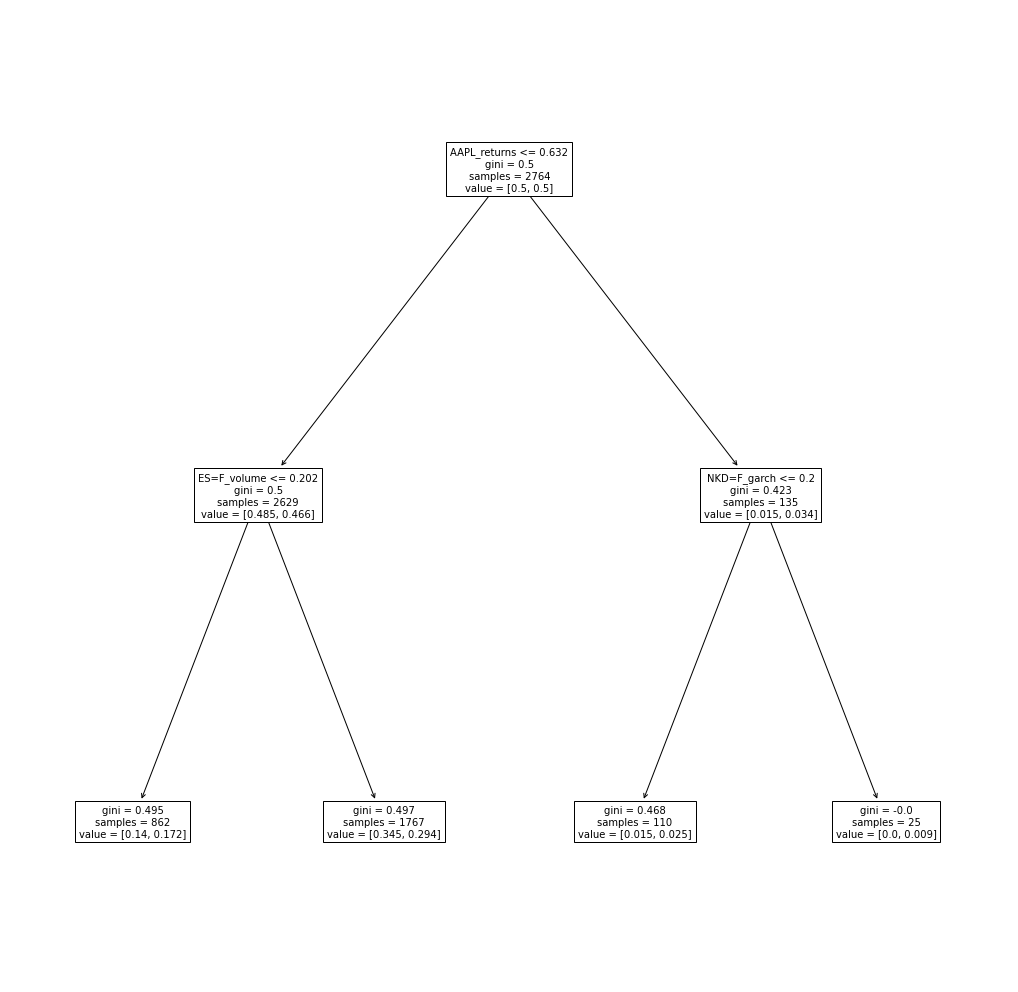

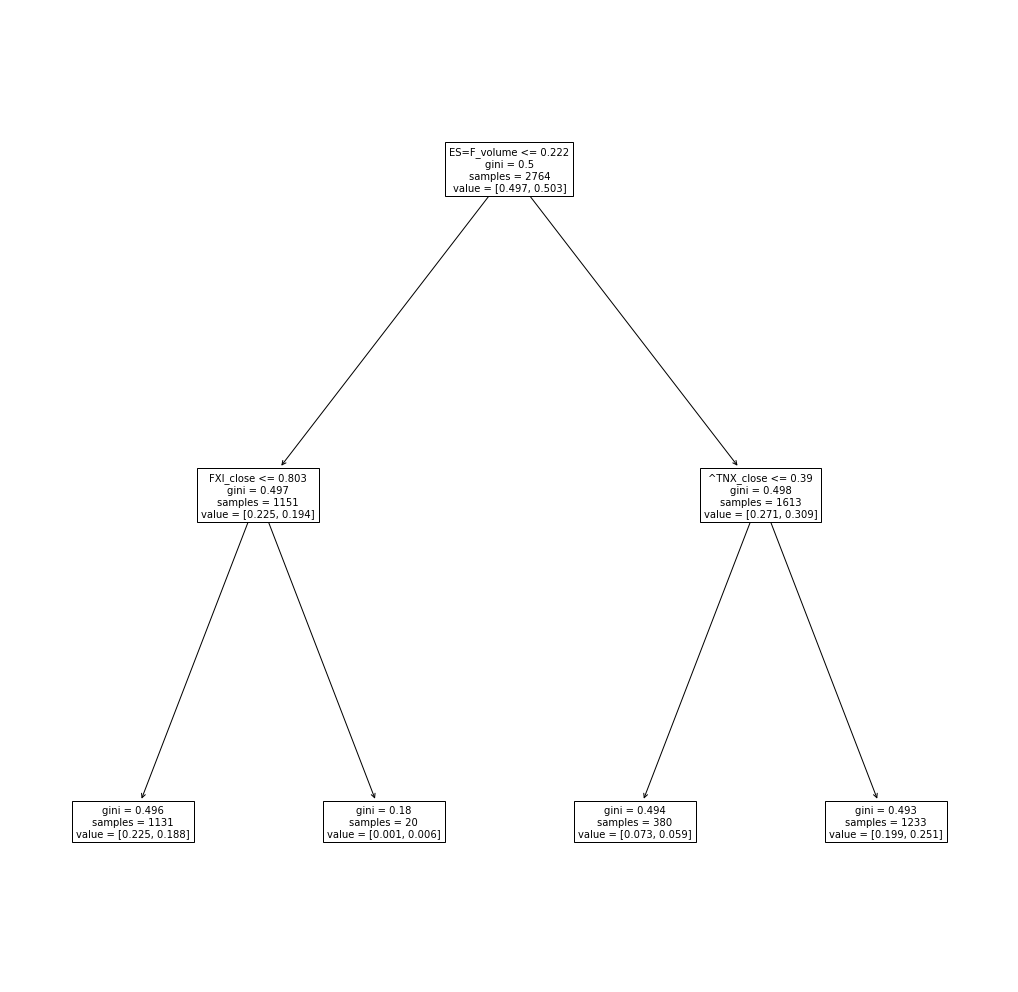

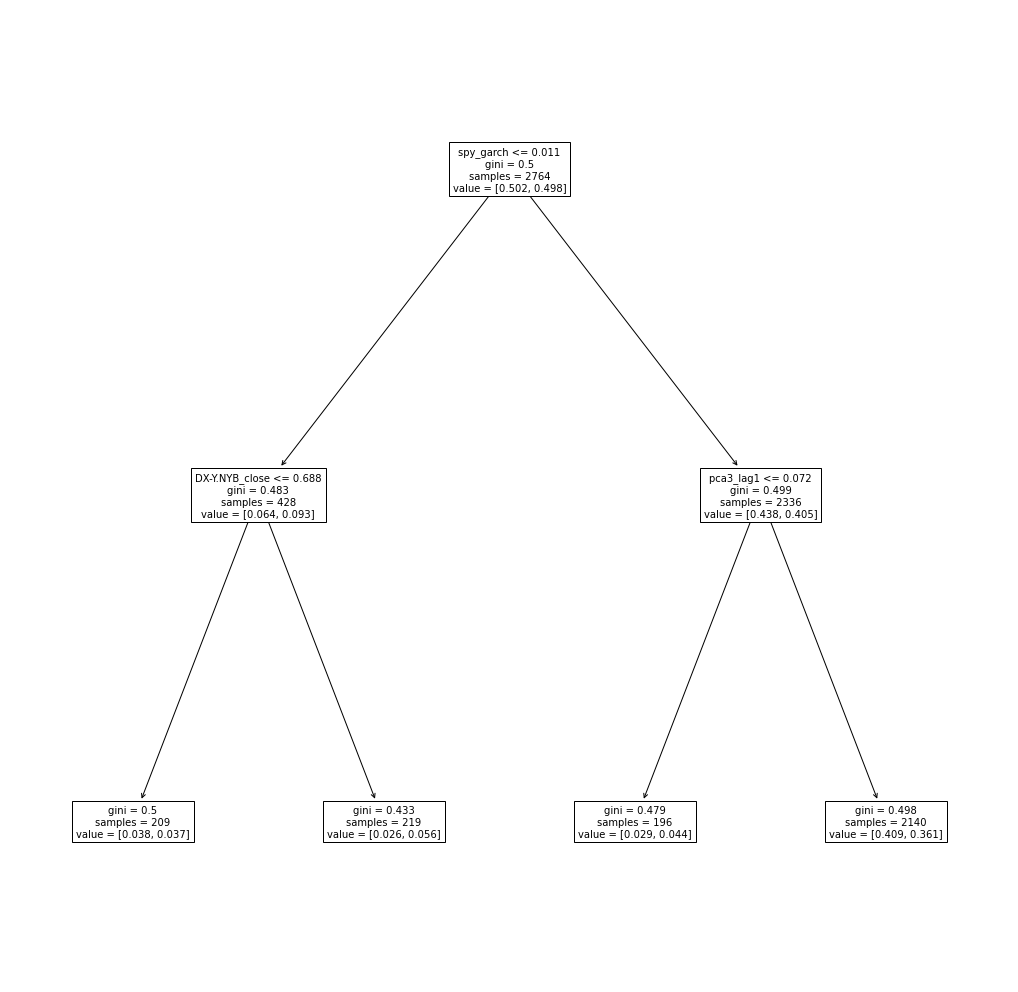

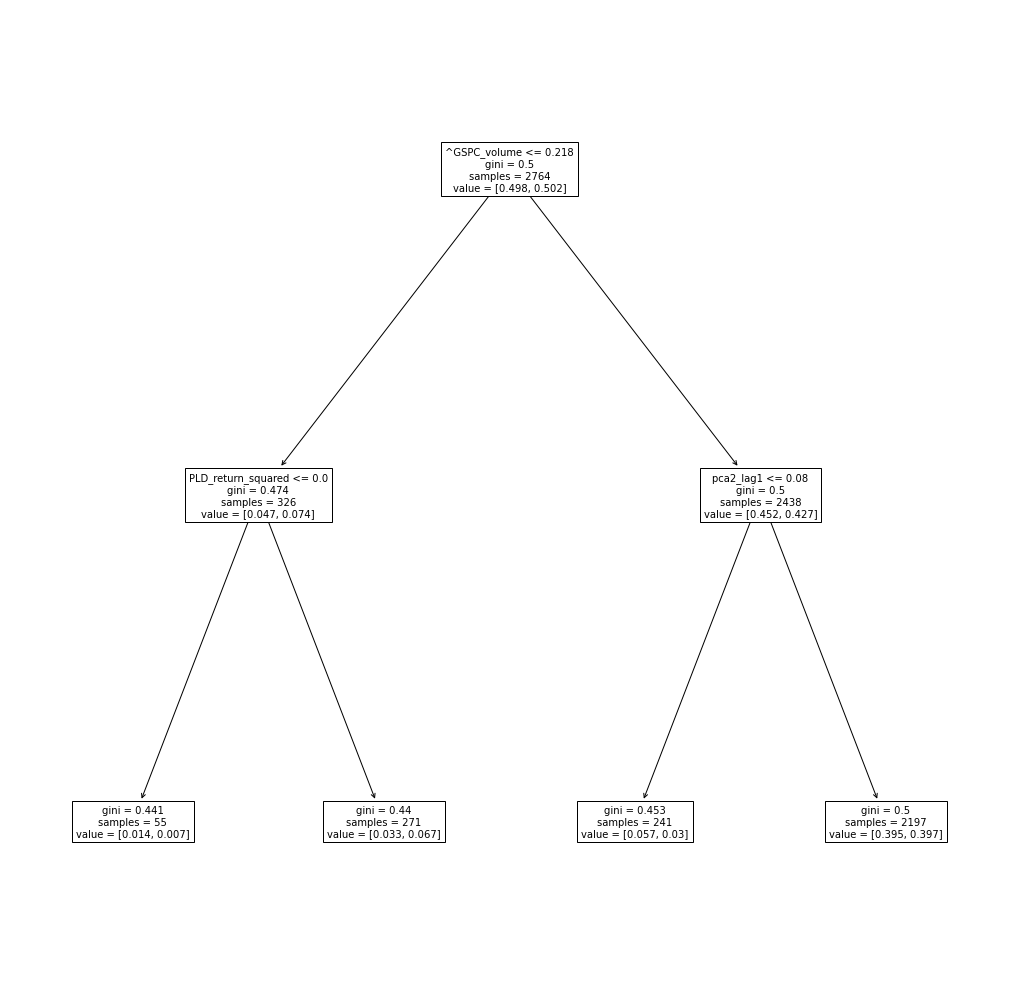

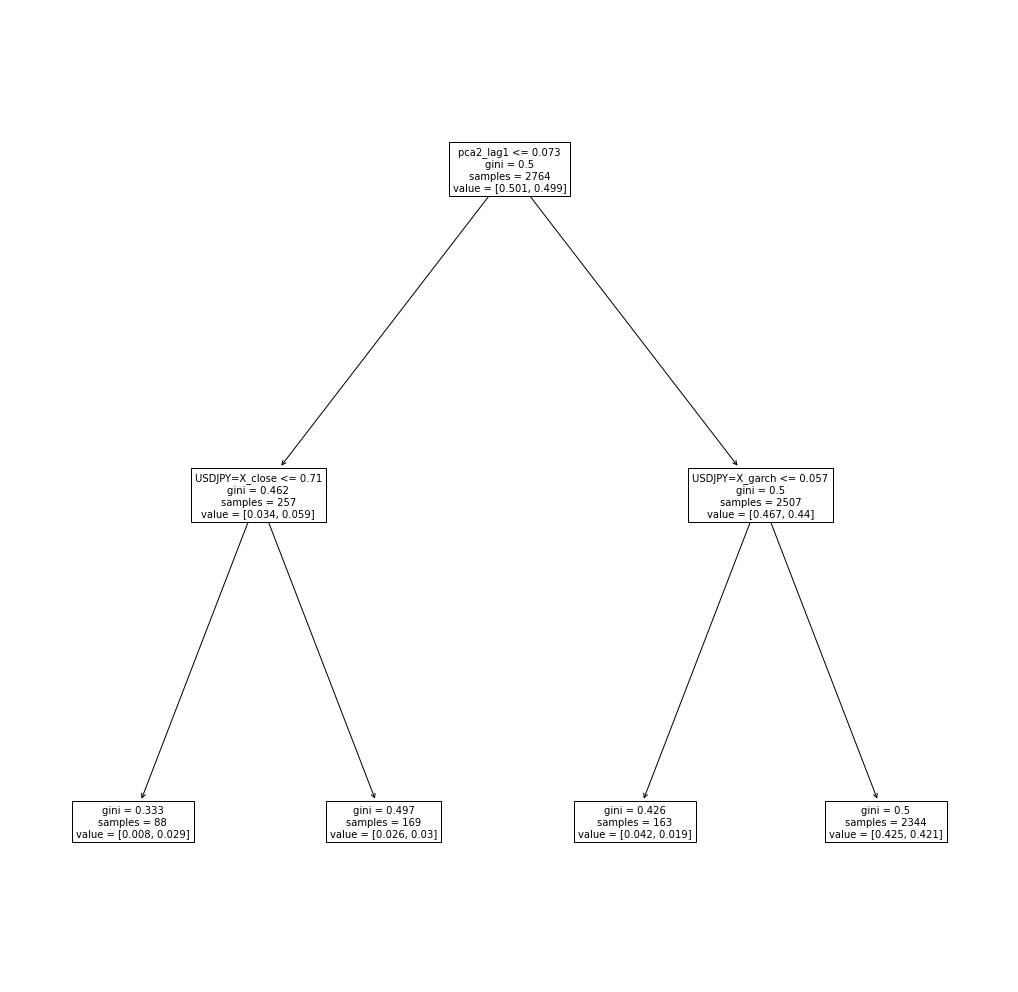

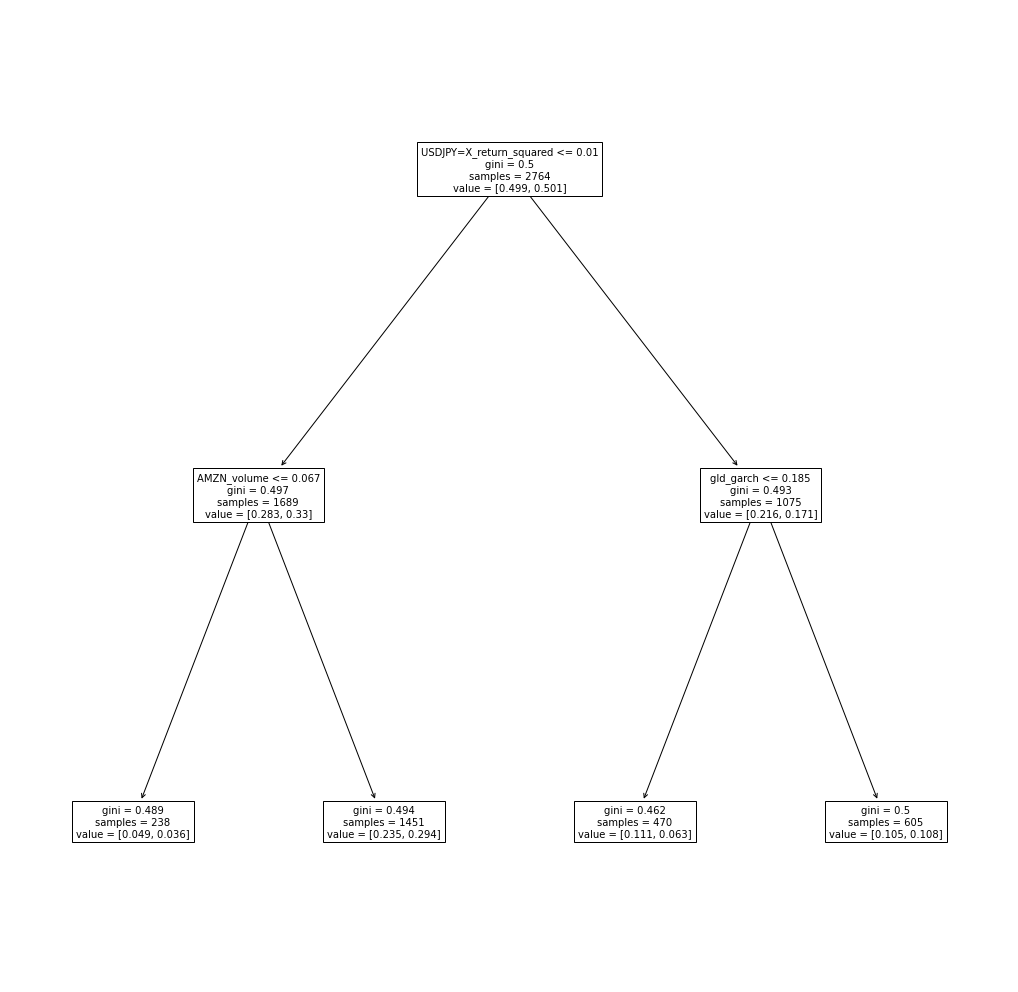

In [47]:
#from sklearn import tree
#adaboost_model.estimators_
#tree.plot_tree(adaboost_model.estimators_[0],fontsize=10)

#import matplotlib.pyplot as plt
# plot tree

for i in range(0,len(adaboost_model.estimators_)):
    plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
    tree.plot_tree(adaboost_model.estimators_[i],fontsize=10, feature_names=X.columns, proportion=False)
    plt.show()

# Profitability Analysis


In [48]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics = abs(100 * security_returns_df['VIXM']).describe()
display(vixm_return_statistics)

count    2900.000000
mean        1.395715
std         1.501480
min         0.000000
25%         0.434465
50%         0.994112
75%         1.875514
max        18.214719
Name: VIXM, dtype: float64

In [49]:
#vixm_ret.loc['2011-02-21']
#y_train_df.index.min()  
#y_train_df.index.max()

### In-sample analysis: Return on $1 invested on training data window

In [50]:
# Results comnparison

# Profitability on the train window
fit_train    = adaboost_model.predict(X_train_scaled)
fit_train_df = pd.DataFrame(fit_train, index = X_train.index)

fit_train_df.hvplot()

y_train_df = pd.DataFrame(y_train, index=X_train.index)
y_train_df

vixm_returns_train_df = vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
vixm_returns_train_df = vixm_returns_train_df.loc[y_train_df.index]


# SPY as benchmark
spy_in_sample_period_returns = security_returns_component_df['spy'].loc[y_train_df.index.min():y_train_df.index.max()]


results_train_df = pd.concat([vixm_returns_train_df, y_train_df, fit_train_df, spy_in_sample_period_returns], axis=1)
print(results_train_df)

results_train_df.columns=['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY returns"]

predicted_return = np.multiply(results_train_df['VIXM Return'],results_train_df['Fit Signal'])
max_return       = np.multiply(results_train_df['VIXM Return'],results_train_df['Correct Signal'])


results_train_df = pd.concat([results_train_df, predicted_return, max_return], axis=1)
print(results_train_df)
results_train_df.columns = ['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY Return", 'VIXCOIN Token Return', "Max Return"]


return_of_one_dollar_in_train_window_df = (1+results_train_df[['VIXM Return', "SPY Return", 'VIXCOIN Token Return', "Max Return"]]).cumprod()
return_of_one_dollar_in_train_window_df.columns=['VIXM ETN', "SPY Return", 'VIXCOIN Token(in sample)', "Max Return"]

profitability_train_plot=return_of_one_dollar_in_train_window_df[['VIXCOIN Token(in sample)','VIXM ETN' ]].hvplot(
                                             title="In-Sample Growth of $1 initial Investment in VIXCOIN Token",
                                             ylabel="Dollars $" ,
                                             width=1000,
                                             color=['green','red','blue']
 )

profitability_train_plot
#results_train_df[["Correct Signal", "Fit Signal"]].head(20)
#(1+predicted_return).cumprod().tail(400)
#return_of_one_dollar_in_train_window_df.tail()

            VIXM_ret  Signal    0       spy
Date                                       
2011-02-21  0.000000     1.0  1.0  0.000000
2011-02-22  0.059293     1.0  0.0 -0.020070
2011-02-23  0.026566     1.0  1.0 -0.006145
2011-02-24  0.001107     1.0  1.0 -0.000687
2011-02-25 -0.035941     0.0  1.0  0.010693
...              ...     ...  ...       ...
2021-02-15  0.000000     1.0  1.0  0.000000
2021-02-16  0.001446     1.0  1.0 -0.000866
2021-02-17 -0.001925     0.0  0.0  0.000229
2021-02-18  0.011333     1.0  1.0 -0.004256
2021-02-19  0.000477     1.0  0.0 -0.001766

[2610 rows x 4 columns]
            VIXM Return  Correct Signal  Fit Signal  SPY returns         0  \
Date                                                                         
2011-02-21     0.000000             1.0         1.0     0.000000  0.000000   
2011-02-22     0.059293             1.0         0.0    -0.020070  0.000000   
2011-02-23     0.026566             1.0         1.0    -0.006145  0.026566   
2011-02-24   

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [51]:
y_train_df.index

DatetimeIndex(['2011-02-21', '2011-02-22', '2011-02-23', '2011-02-24',
               '2011-02-25', '2011-02-28', '2011-03-01', '2011-03-02',
               '2011-03-03', '2011-03-04',
               ...
               '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
               '2021-02-12', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19'],
              dtype='datetime64[ns]', name='Date', length=2610, freq='B')

### Out-of--sample analysis: Return on $1 invested on training data window

In [52]:
# Results comnparison

# Profitability on the test window

# Out-of-sample Predictions 
prediction_test = adaboost_model.predict(X_test_scaled)
prediction_test_df= pd.DataFrame(prediction_test, index = X_test.index)

# Out-of-sample signals (1s or 0s) based on actual returns of the VIX
y_test_df=pd.DataFrame(y_test, index=X_test.index)
y_test_df

# VIXM returns in the test window
vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

# Combination of VIXM Returns, signals and predictions
results_test_df = pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
results_test_df.columns = ['VIXM Return', 'Correct Signal', 'Predicted Signal']

# Predicted returns
predicted_return=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
max_return=results_test_df['VIXM Return']*results_test_df['Correct Signal']

# SPY as benchmark
spy_out_of_sample_period_returns=security_returns_component_df['spy'].loc[y_test_df.index]

# DataFrame with out-of-sample results for comparison
results_test_df=pd.concat([results_test_df, predicted_return, max_return, spy_out_of_sample_period_returns], axis=1)
results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Predicted Return', "Max Return", "Benchmark: SPY"]

return_of_one_dollar_in_test_window_df=(1+results_test_df[['Predicted Return','VIXM Return',  "Benchmark: SPY"]]).cumprod()
return_of_one_dollar_in_test_window_df.columns=['VIXCOIN Token (out of sample)', 'VIXM ETN', 'Benchmark: SPY ETF']


#Plot with out of sample return on a 1 dollar investment for the VIX, and the daily bet strategy

# Set plot and style options
roi_token=-1+return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].iloc[-1]
roi_etn=-1+return_of_one_dollar_in_test_window_df['VIXM ETN'].iloc[-1]
roi_spy=-1+return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].iloc[-1]

title=f" Growth of $1 investment in VIXCOIN Token since October 2019.    Token Return: {roi_token*100:.1f}%  ETN Return: {roi_etn*100:.1f}% SPY Return: {roi_spy*100:.1f}%"
profitability_test_plot=return_of_one_dollar_in_test_window_df.hvplot(
                         title=title,
                         ylabel= "Dollars $",
                         width=1200,
                         height=500,
                         color=["green","red","blue"]
                         #,legend="bottom"
                        
                )

profitability_test_plot

#predicted_return.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [53]:
y_test.index

DatetimeIndex(['2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-03-01', '2021-03-02', '2021-03-03',
               '2021-03-04', '2021-03-05',
               ...
               '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-14'],
              dtype='datetime64[ns]', name='Date', length=276, freq='B')

In [54]:
# Bar graph comparison of returns
start_date_plot = str(results_test_df.index[0].date())
title = f"Out-of-Sample Cummulative Return on Investment Comparison. Starting period: {start_date_plot}"
roi_plot_df         = (100*return_of_one_dollar_in_test_window_df)
roi_plot_df.columns = ["VIXCOIN Token", "VIXM ETN", "SPY ETF"]
roi_plot_df         = roi_plot_df.iloc[-1]

roi_plot_df.hvplot(
    kind   = 'bar',
    ylabel = 'Return (%)',
    title  = title
    )


:Bars   [index]   (2022-03-14 00:00:00)

In [55]:
# Token growth in out-of.sample window. Like a pricing example if token is set to $1 at the start of the testing window
# Generating a plot that contains the growth of the Token compared to the SPY since Oct 2019. 
# Key points are marked "^" to emphasize levels like maximum, minimum, first, last.

# Set plot and style options
roi_token=(1+predicted_return).cumprod()[-1]
title=f"VIXCOIN Token Pricing example, if initiated in Feb 2021.                Current price: {roi_token:.2f}"

token_price_curve_plot=return_of_one_dollar_in_test_window_df.hvplot(
                         y=['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF'],
                         title=title,
                         ylabel= "Dollars $",
                         width=1100,
                         color=["green","blue"])

first_point=return_of_one_dollar_in_test_window_df.head(1)
last_point =return_of_one_dollar_in_test_window_df.tail(1)
max_token  =return_of_one_dollar_in_test_window_df[return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)']==return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].max()].head(1)
min_spy    =return_of_one_dollar_in_test_window_df[return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF']==return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].min()].head(1)

key_points=pd.concat([first_point, min_spy, max_token, last_point], axis=0)
key_points_token=key_points['VIXCOIN Token (out of sample)']
key_points_spy=key_points['Benchmark: SPY ETF']



token_key_point=return_of_one_dollar_in_test_window_df[['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF']].loc[key_points.index].hvplot(
                kind='scatter',
                marker="^",
                size=200,
                legend=False,
                ylabel='Price in $',
                width=1000,
                height=400,
                color=['green','blue']
)

token_key_point*token_price_curve_plot



:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Scatter   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [56]:
key_points.index

DatetimeIndex(['2021-02-22', '2021-03-04', '2022-03-14', '2022-03-14'], dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
prediction_test_df.hvplot(width=1200, kind='bar', color=['black'])*(5*vixm_returns_df).hvplot(kind='bar', color=["yellow"],
                                                                            title="How the algorithm avoids time decay?",
                                                                            ylabel="Signal and VIXMx5 return")

In [ ]:
# TOKEN PRICE and JASON FILE
date_start_token='2020-12-31'
date_after_start_token='2021-1-1'

# output for jason
# csv file with [token value, VIXM, SPY] for all history 
y_hat_df=pd.concat([fit_train_df, prediction_test_df], axis=0)
y_hat_df.columns=['Signal_hat']
jason_df=pd.concat([y_hat_df, X2['VIXM_returns'], X2['spy_returns'],X1['VIXM_close'], X1['spy_close']], axis=1)

growth_1dollar_investment_df=(1+jason_df[['VIXM_returns', 'spy_returns']]).cumprod()
print(growth_1dollar_investment_df)
growth_1dollar_investment_df.rename({'VIXM_returns':'VIXM_growth_1dollar', 'spy_returns':'spy_growth_of_1dollar'}, axis=1, inplace=True)



jason_df=pd.concat([jason_df,growth_1dollar_investment_df],axis=1)

jason_df["Signal_hat"]=jason_df["Signal_hat"].fillna(0)

token_returns=np.multiply(jason_df['Signal_hat'], jason_df['VIXM_returns'])
token_returns.rename({"0":"Token_Returns"}, axis=1, inplace=True)
token_returns=token_returns.fillna(0)
token_growth_df=(1+token_returns).cumprod()



token_growth_df.rename({"0":"Token_Growth"}, axis=1, inplace=True)

token_price_df=token_growth_df.copy()
token_price_df[token_price_df.index<date_start_token]=0
token_price_df[token_price_df.index>=date_start_token]=token_growth_df[token_growth_df.index>=date_start_token]/token_growth_df[date_start_token]


jason_df=pd.concat([jason_df,token_returns, token_growth_df, token_price_df],axis=1)
print(f"jason_df:{jason_df}  ")

jason_df.columns=['Signal_hat',
                  'VIXM_returns',
                  'spy_returns',
                  'VIXM_close',
                  'spy_close',
                  'VIXM_growth_1dollar',
                  'spy_growth_of_1dollar',
                  'Token_returns',
                  'VIXCOIN_token_growth_1dollar',
                  'Token_price'
]


#print(y_hat_df)
#print(jason_df.loc['2011-02-21':])
jason_df=jason_df.dropna()
jason_df.to_csv("demo_data/Jason_output_file.csv", index=True)


# Token graph
spy_growth_vs_token= pd.DataFrame((1+security_returns_df.loc[date_after_start_token:,['spy', "VIXM"]]).cumprod(), index=security_returns_df.loc[date_start_token:,'spy'].index)
spy_growth_vs_token.loc[date_start_token,['spy', "VIXM"]]=1
spy_growth_vs_token['Token']=jason_df.loc[date_start_token:,'Token_price']


token_price_vs_vixm = spy_growth_vs_token.iloc[:,1:3]

title =f"VIXCOIN Token Price.                                                   Price as of {end_date}: ${token_price_df[-1]:.2f}"

graph2=token_price_vs_vixm.hvplot(
    legend = 'bottom',
    title  = title,
    height = 500,
    ylabel = "$",
    color  =[ 'red', 'green']
)


display(graph2)

#print(jason_df[['spy_growth_of_1dollar','Growth_1dollar_invested_in_token_same_as_Token_Price_if_started_on_2011', 'VIXM_growth_1dollar' ]])

spy_growth_vs_token



### Comments
0. The VIXM invest in VIX Futures in order to make profit.
1. The VIXM has massive positive returns in moments of crushes in the market, and tends to decay in time due to the rolling effect on its futures contracts. 
2. Due to the decay effect, VIXM can only be profitable for short term trades. Should not be used in a buy and hold strategy.
3. Our algorithmic trading investment strategy on VIXM takes advantage of the good return in market crushes, and in addition allows to generate profit during bull markets.
4. The VIXCoin investment works like a buy and hold strategy, and offers an investment opportunity to diversify a portfolio to reduce risk.


In [ ]:
# Results in prediction of daily returns
min_return=threshold
results_test_for_plot_df=results_test_df[abs(results_test_df['VIXM Return'])>min_return]*100

results_test_for_plot_df.hvplot(
                    y=['VIXM Return', 'Predicted Return'],
                    title= "Out-of-sample predictions of VIXM return",
                    width=1000,
                    ylabel='Daily Return (%)'
)

In [ ]:
#Histogram of returns out of sample
results_test_for_plot_df.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIXM returns predictions"
)

### Analysis of good and bad predictions

In [ ]:
# Analysis of the good and bad out-of-sample predictions
good_predictions=results_test_df[results_test_df['Correct Signal']==results_test_df['Predicted Signal']]

bad_predictions=results_test_df[results_test_df['Correct Signal']!=results_test_df['Predicted Signal']]


In [ ]:
good=good_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns of Good Predictions"
)

bad=bad_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns on Bad Predictions"
)
good+bad

### Observations
We see that the number of negative returns that are dismissed are similar to the ones avoided when returns are small. However, for large tailed negative returns, there are significantly many more that are avoided (9+6 =15) than the ones that are not avoided (3+1 = 4 )

In [ ]:
# Good prediction statistics
good_predictions[['VIXM Return', 'Predicted Return']].describe()

In [ ]:
# Bad prediction statistics
bad_predictions[['VIXM Return', 'Predicted Return']].describe()

In [ ]:
# Box Plot predictions for good and bad predictions
good_pred=good_predictions['Predicted Return']
bad_pred =bad_predictions['Predicted Return']

predictions_comparison_df=pd.concat([good_predictions['Predicted Return'],bad_predictions['Predicted Return']], axis=1, ignore_index=True )*100
predictions_comparison_df.hvplot(kind='box',
                                height=800,
                                ylabel='Return (%)',
                                #clabel=['Good Predictions', 'Bad Predictions'],
                                cmap=['blue','red'],
                                title="Out-of-sample Good and Bad Returns Resulting from Model Predictions Box Plots")





#df = pd.DataFrame(np.random.randn(20), columns=['Value'])
#df['Source'] = ['Preds'] *10 +['Real'] * 10
#df['Item'] = ['item1'] *5 + ['item2']*5 + ['item1'] *5 + ['item2']*5
#df.hvplot.box(y='Value', by=['Item', 'Source'])

#n_estimators 22, Trying deph 1, learning rate 1.8 -- get to perfect accuracy.

# Tunning
### OUTPUTS FOR TUNNING

In [ ]:
def prepare_features(XY, pca_components):
    XY_modified = XY.shift().dropna()
    y = XY_modified["Signal"].shift(-1)
    X = XY_modified
    pca = PCA(n_components = pca_components)
    principal_components = pca.fit_transform(X)
    
    pca_column_list = []
    for i in range(1, pca_components+1):
        pca_column_list.append(f"pca{i}")

    principal_components_train_test_df = pd.DataFrame(data = principal_components, columns = pca_column_list, index = XY_modified.index)
    X_pca_lag1 = create_pca_lag1(principal_components_train_test_df)
    X_pca_lag2 = create_pca_lag2(principal_components_train_test_df)
    X_pca_lag3 = create_pca_lag3(principal_components_train_test_df)
    X_pca_lag4 = create_pca_lag4(principal_components_train_test_df)
    X_pca_lag5 = create_pca_lag5(principal_components_train_test_df)
        
    X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)
    X_pc = concatenate_pca_with_lags(principal_components_train_test_df, X_pc_lags)
    X, y = eliminate_nans_in_pca_data(X_pc, y)
    
    X_train, y_train, X_test, y_test = split_training_test_data(X, y)
    X_train_resampled, y_train_resampled = random_over_sample(X_train, y_train)
    X_train_scaled, X_test_scaled = standard_scale(X_train_resampled, X_test)
    #principal_components_train_test
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
    return X_train_scaled, X_test_scaled, y_train_resampled, y_test

In [ ]:
# GENERATING TUNING ON TRAIN

if run_multiple_tuning_iterations == True: 
    for num_estimators in range (1,25, 1):
        for depth in range(1,3,1):
            for rate in range(9,19,1):
                base = DecisionTreeClassifier(max_depth=depth)
                adaboost_model=AdaBoostClassifier(base_estimator=base, 
                                      n_estimators=num_estimators, 
                                      learning_rate= rate/10 )

                # Fit the model 
                adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)
                
                pred_adaboost= adaboost_model.predict(X_train_scaled)
                prediction_train_df= pd.DataFrame(pred_adaboost, index=X_train.index)
                
                #Calculate Peofitability
                # VIXM returns in the test window
                vixm_returns_df=vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
                vixm_returns_train_df = vixm_returns_df.loc[y_train_df.index]

                # Combination of VIXM Returns, signals and predictions
                results_train_df=pd.concat([vixm_returns_train_df, y_train_df, prediction_train_df], axis=1)
                results_train_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal']

                # Predicted returns (we don't use the correct signal, but the predicted signal)
                predicted_return_df=results_train_df['VIXM Return']*results_train_df['Predicted Signal']
                predicted_return_df.columns=['Date','VIXM_Strategy_return']
                roi_strategy_factor = (1+predicted_return_df).cumprod()[-1]
                             
        
                # Use a classification report to evaluate the model using the predictions and testing data
                adaboost_report=classification_report(y_train, pred_adaboost)

                #if num_estimators % 10 == 0 and num_components == 88:
                #    print(f"components {num_components} esimators {num_estimators}")
                #    print(f"f1 score 0 {f1_score(y_test, pred_adaboost, pos_label=0)} f1 score 1 {f1_score(y_test, pred_adaboost, pos_label=1)}")
                #    print(f"accuracy {accuracy_score(y_test, pred_adaboost)}")
                #    print(adaboost_report)
                f1_score_1 = f1_score(y_train, pred_adaboost, pos_label=1)
                f1_score_0 = f1_score(y_train, pred_adaboost, pos_label=0)
                recall_score_1 = recall_score(y_train, pred_adaboost, pos_label=1)
                recall_score_0 = recall_score(y_train, pred_adaboost, pos_label=0)
                accuracy_score_model = accuracy_score(y_train, pred_adaboost)
                if  accuracy_score_model >= .55 and f1_score_1 >= .55 and f1_score_0 >= .55 and recall_score_1 >= .55 and recall_score_0 >= .55 and roi_strategy_factor>10 :
                    print(f"n_estimators {num_estimators}, max tree deph: {depth},learning_rate:{rate/10}, growth of one dollar investment:{roi_strategy_factor}")
                    # print(f"variance explained {sum(pca.explained_variance_ratio_)}")
                    # Print the classification report
                    print("         AdaBoost Classification Report")
                    print(adaboost_report)
                print(f"n_estimators {num_estimators}, Trying deph {depth}, learning rate {rate/10}")

In [ ]:
# GENERATING TUNING ON TEST RESULTS

if run_multiple_tuning_iterations == True: 
    for num_estimators in range (1,25, 1):
        for depth in range(1,3,1):
            for rate in range(1,20,1):
                base = DecisionTreeClassifier(max_depth = depth)
                adaboost_model=AdaBoostClassifier(base_estimator = base, 
                                      n_estimators = num_estimators, 
                                      learning_rate = rate/10 )

                # Fit the model 
                adaboost_model     = adaboost_model.fit(X_train_resampled, y_train_resampled)
                pred_adaboost      = adaboost_model.predict(X_test_scaled)
                prediction_test_df = pd.DataFrame(pred_adaboost, index=X_test.index)
                
                #Calculate Peofitability
                # VIXM returns in the test window
                vixm_returns_df = vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
                vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

                # Combination of VIXM Returns, signals and predictions
                results_test_df = pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
                results_test_df.columns = ['VIXM Return', 'Correct Signal', 'Predicted Signal']

                # Predicted returns (we don't use the correct signal, but the predicted signal)
                predicted_return_df=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
                predicted_return_df.columns=['Date','VIXM_Strategy_return']
                roi_strategy_factor = (1+predicted_return_df).cumprod()[-1]
                             
        
                # Use a classification report to evaluate the model using the predictions and testing data
                adaboost_report = classification_report(y_test, pred_adaboost)

                #if num_estimators % 10 == 0 and num_components == 88:
                #    print(f"components {num_components} esimators {num_estimators}")
                #    print(f"f1 score 0 {f1_score(y_test, pred_adaboost, pos_label=0)} f1 score 1 {f1_score(y_test, pred_adaboost, pos_label=1)}")
                #    print(f"accuracy {accuracy_score(y_test, pred_adaboost)}")
                #    print(adaboost_report)
                f1_score_1 = f1_score(y_test, pred_adaboost, pos_label=1)
                f1_score_0 = f1_score(y_test, pred_adaboost, pos_label=0)
                recall_score_1 = recall_score(y_test, pred_adaboost, pos_label=1)
                recall_score_0 = recall_score(y_test, pred_adaboost, pos_label=0)
                accuracy_score_model = accuracy_score(y_test, pred_adaboost)
                if  accuracy_score_model >= .50 and f1_score_1 >= .50 and f1_score_0 >= .50 and recall_score_1 >= .50 and recall_score_0 >= .50 and roi_strategy_factor>1 :
                    print(f"estimators {num_estimators}, max tree deph: {depth},learning_rate:{rate/10}, growth of one dollar investment:{roi_strategy_factor}")
                    # print(f"variance explained {sum(pca.explained_variance_ratio_)}")
                    # Print the classification report
                    print("         AdaBoost Classification Report")
                    print(adaboost_report)
                print(f"Trying n_estimators {num_estimators}, deph {depth},  learning rate {rate/10}")